# Semantic Segmentation of Glomeruli

DATS 6202  
Machine Learning 1  
Jongchan Kim 

## 1. Introduction

### 1.1 Glomeruli

The glomerulus (plural glomeruli) is a network of a small blood vessels
located at the beginning of a nephron in the kidney.  Glomeruli are mainly found in the renal **cortex**, while the renal medulla contains mainly the renal tubule.

*Fig 1. Diagram of a nephron*

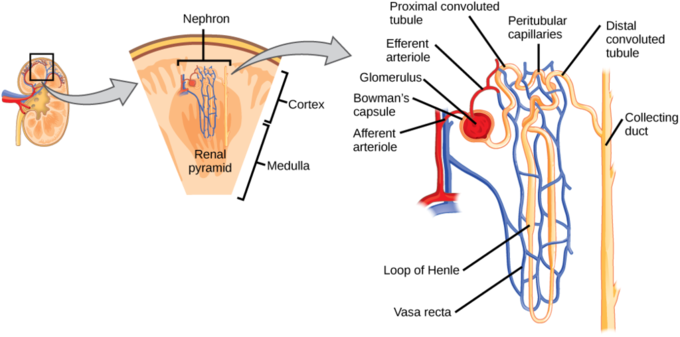

Image Credits : https://bio.libretexts.org/Bookshelves/Introductory_and_General_Biology/Book%3A_General_Biology_(Boundless)/41%3A_Osmotic_Regulation_and_the_Excretory_System/41.4%3A_Human_Osmoregulatory_and_Excretory_Systems/41.4B%3A_Nephron%3A_The_Functional_Unit_of_the_Kidney

### 1.2 Goal  
The Goal of this project is to develope segmenation algorithms that identify glomeruli in the PAS stained microscopy data.

*Fig 2. Examples of PAS stained microscopy image*

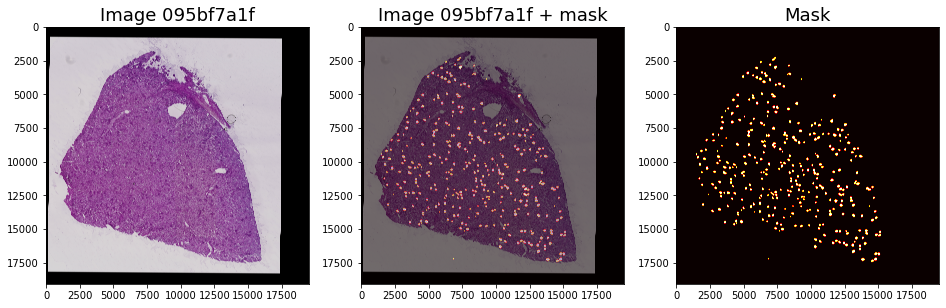

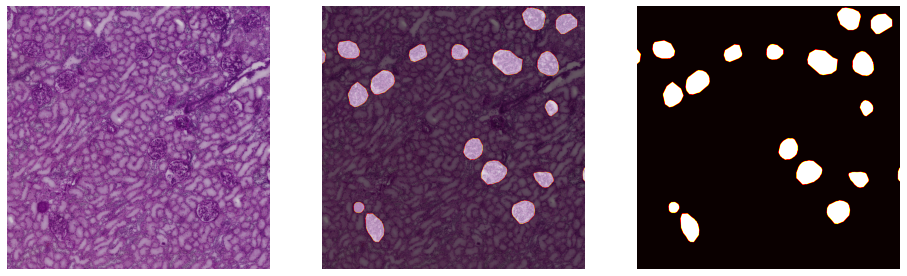

Image Credits : https://www.kaggle.com/ihelon/hubmap-exploratory-data-analysis

### 1.3 Metric : Dice Coefficient

*Fig 3. Dice coefficient*

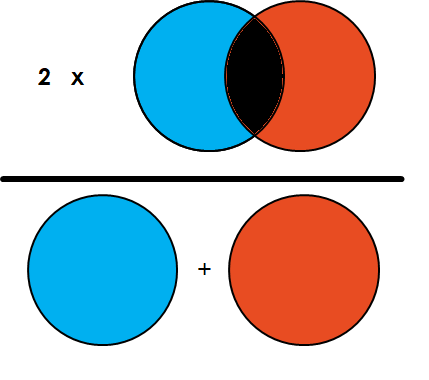

Image Credits: https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

Dice coefficient, is a statistical tool which measures the similarity between two sets of data.  
The formula is given by:
2∗|X∩Y| / |X|+|Y| 
where X is the predicted set of pixels and Y is the ground truth.

### 1.4 UNET Architecture and Training

The UNET was developed for biomedical image segmentation.
The architecture contains two paths. First path is the contraction path(also called as the encoder). The encoder is just a traditional stack of convolutional and max pooling layers. The second path is the symmetric expanding path(also called decoder) which is used to enable precise localization using transposed convolutions. 

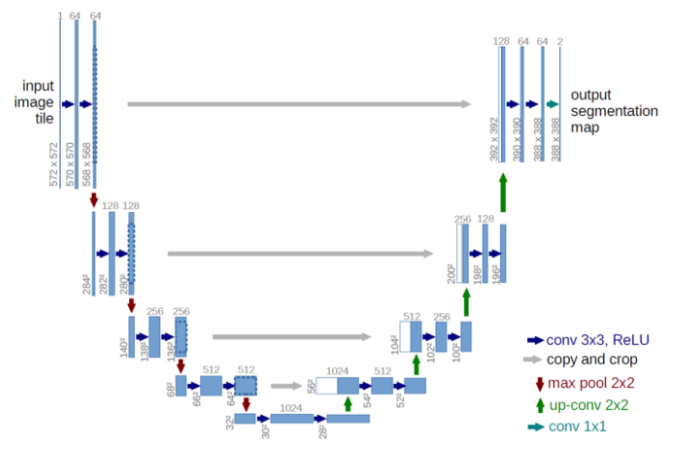

Image Credits : https://arxiv.org/abs/1505.04597

The backbone is the architectural element which defines how these these layers are arranged in the encoder network and they determine how the decoder network should be built. The backbone used are often Vanilla CNNs such as VGG, ResNet, Inception, EfficientNet etc which performs encoding and downsampling by itself. These networks are taken and their counter parts are built to perform decoding and upsampling to form the final Unet.

## 2. Experiment

### 2.1 Colab Mouting and Basic Path Setting

In [1]:
# google drive
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/final/'

Mounted at /content/drive


### 2.2 Install and Import Packages

In [2]:
!pip install fastai --upgrade 
!pip install segmentation_models_pytorch
!pip install deepflash2
!pip install imagecodecs
!pip install -qq zarr

     |████████████████████████████████| 194kB 11.3MB/s 
     |████████████████████████████████| 12.8MB 19.8MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 71kB 6.8MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 245kB 26.7MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=

In [3]:
import cv2, zarr, tifffile, json, gc 
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from pathlib import Path
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'

gc.enable()

# im
import albumentations as alb

%tensorflow_version 2.x 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from fastai.vision.all import *
import segmentation_models_pytorch as smp
from deepflash2.all import *
import tifffile
import imagecodecs

### 2.3 Random Seed

In [4]:
# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

### 2.4 Data Preprocessing

#### 2.4.1 Change Image data format from Tiff to Zarr  
- The dataset is comprised of very large (>500MB - 5GB) TIFF files.
- Slicing the images would be necessary for training.
- Zarr is a format for the storage of chunked, compressed, N-dimensional arrays based on Numpy.
- Zarr enables to open the image without loading the entire image into the memory - this is important for sampling the tiles.

In [33]:
def read_image(image_id, path, scale=None, verbose=1):
    "Load images with ID from path"
    
    image = tifffile.imread(path/f"train/{image_id}.tiff")
    
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    elif image.shape[0] == 3:
        image = image.transpose(1, 2, 0)
    
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
        
    return image

In [34]:
scale = 2 # downsizing

path = Path(abspath_curr+"/input") # basic path to data

df_train = pd.read_csv(path/"train.csv") # contains ids of images

g_out = zarr.group(abspath_curr + f'/working/zarr_scale{scale}') # path to store zarr files 

[2f6ecfcdf] Image shape: (31278, 25794, 3)
[2f6ecfcdf] Resized Image shape: (15639, 12897, 3)
Name               : /2f6ecfcdf
Type               : zarr.core.Array
Data type          : uint8
Shape              : (15639, 12897, 3)
Chunk shape        : (978, 1613, 1)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 605088549 (577.1M)
No. bytes stored   : 394838483 (376.5M)
Storage ratio      : 1.5
Chunks initialized : 384/384



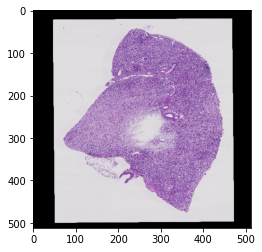

[8242609fa] Image shape: (31299, 44066, 3)
[8242609fa] Resized Image shape: (15649, 22033, 3)
Name               : /8242609fa
Type               : zarr.core.Array
Data type          : uint8
Shape              : (15649, 22033, 3)
Chunk shape        : (979, 2755, 1)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 1034383251 (986.5M)
No. bytes stored   : 820431590 (782.4M)
Storage ratio      : 1.3
Chunks initialized : 384/384



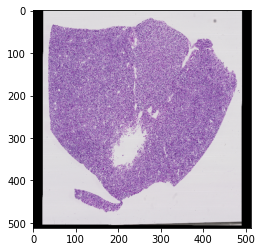

[aaa6a05cc] Image shape: (18484, 13013, 3)
[aaa6a05cc] Resized Image shape: (9242, 6506, 3)
Name               : /aaa6a05cc
Type               : zarr.core.Array
Data type          : uint8
Shape              : (9242, 6506, 3)
Chunk shape        : (1156, 814, 1)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 180385356 (172.0M)
No. bytes stored   : 139892780 (133.4M)
Storage ratio      : 1.3
Chunks initialized : 192/192



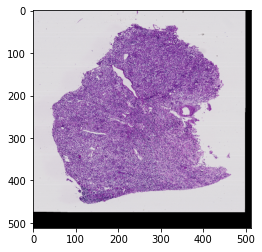

[cb2d976f4] Image shape: (34940, 49548, 3)
[cb2d976f4] Resized Image shape: (17470, 24774, 3)
Name               : /cb2d976f4
Type               : zarr.core.Array
Data type          : uint8
Shape              : (17470, 24774, 3)
Chunk shape        : (1092, 1549, 1)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 1298405340 (1.2G)
No. bytes stored   : 899935172 (858.2M)
Storage ratio      : 1.4
Chunks initialized : 768/768



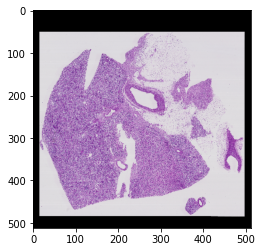

[b9a3865fc] Image shape: (31295, 40429, 3)
[b9a3865fc] Resized Image shape: (15647, 20214, 3)
Name               : /b9a3865fc
Type               : zarr.core.Array
Data type          : uint8
Shape              : (15647, 20214, 3)
Chunk shape        : (978, 2527, 1)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 948865374 (904.9M)
No. bytes stored   : 797265218 (760.3M)
Storage ratio      : 1.2
Chunks initialized : 384/384



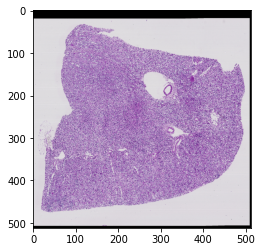

[b2dc8411c] Image shape: (14844, 31262, 3)
[b2dc8411c] Resized Image shape: (7422, 15631, 3)
Name               : /b2dc8411c
Type               : zarr.core.Array
Data type          : uint8
Shape              : (7422, 15631, 3)
Chunk shape        : (928, 1954, 1)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 348039846 (331.9M)
No. bytes stored   : 226739155 (216.2M)
Storage ratio      : 1.5
Chunks initialized : 192/192



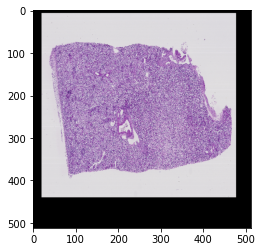

[0486052bb] Image shape: (25784, 34937, 3)
[0486052bb] Resized Image shape: (12892, 17468, 3)
Name               : /0486052bb
Type               : zarr.core.Array
Data type          : uint8
Shape              : (12892, 17468, 3)
Chunk shape        : (806, 2184, 1)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 675592368 (644.3M)
No. bytes stored   : 452740127 (431.8M)
Storage ratio      : 1.5
Chunks initialized : 384/384



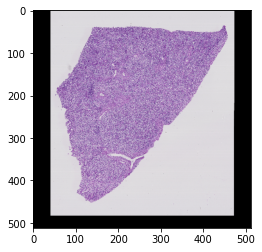

[e79de561c] Image shape: (16180, 27020, 3)
[e79de561c] Resized Image shape: (8090, 13510, 3)
Name               : /e79de561c
Type               : zarr.core.Array
Data type          : uint8
Shape              : (8090, 13510, 3)
Chunk shape        : (1012, 1689, 1)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 327887700 (312.7M)
No. bytes stored   : 280713380 (267.7M)
Storage ratio      : 1.2
Chunks initialized : 192/192



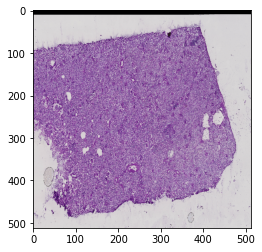

[095bf7a1f] Image shape: (38160, 39000, 3)
[095bf7a1f] Resized Image shape: (19080, 19500, 3)
Name               : /095bf7a1f
Type               : zarr.core.Array
Data type          : uint8
Shape              : (19080, 19500, 3)
Chunk shape        : (1193, 2438, 1)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 1116180000 (1.0G)
No. bytes stored   : 761379861 (726.1M)
Storage ratio      : 1.5
Chunks initialized : 384/384



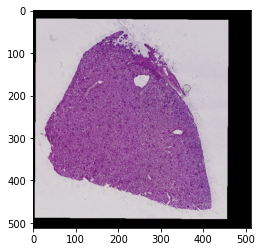

[54f2eec69] Image shape: (30440, 22240, 3)
[54f2eec69] Resized Image shape: (15220, 11120, 3)
Name               : /54f2eec69
Type               : zarr.core.Array
Data type          : uint8
Shape              : (15220, 11120, 3)
Chunk shape        : (952, 1390, 1)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 507739200 (484.2M)
No. bytes stored   : 350545021 (334.3M)
Storage ratio      : 1.4
Chunks initialized : 384/384



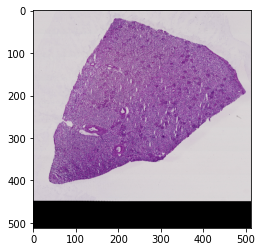

[4ef6695ce] Image shape: (39960, 50680, 3)
[4ef6695ce] Resized Image shape: (19980, 25340, 3)
Name               : /4ef6695ce
Type               : zarr.core.Array
Data type          : uint8
Shape              : (19980, 25340, 3)
Chunk shape        : (1249, 1584, 1)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 1518879600 (1.4G)
No. bytes stored   : 1198290008 (1.1G)
Storage ratio      : 1.3
Chunks initialized : 768/768



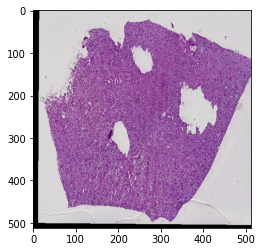

[26dc41664] Image shape: (38160, 42360, 3)
[26dc41664] Resized Image shape: (19080, 21180, 3)
Name               : /26dc41664
Type               : zarr.core.Array
Data type          : uint8
Shape              : (19080, 21180, 3)
Chunk shape        : (1193, 2648, 1)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 1212343200 (1.1G)
No. bytes stored   : 827651005 (789.3M)
Storage ratio      : 1.5
Chunks initialized : 384/384



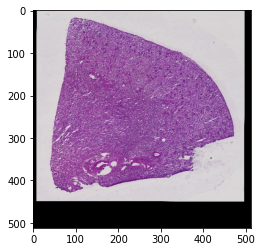

[c68fe75ea] Image shape: (26840, 49780, 3)
[c68fe75ea] Resized Image shape: (13420, 24890, 3)
Name               : /c68fe75ea
Type               : zarr.core.Array
Data type          : uint8
Shape              : (13420, 24890, 3)
Chunk shape        : (839, 3112, 1)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 1002071400 (955.6M)
No. bytes stored   : 920650256 (878.0M)
Storage ratio      : 1.1
Chunks initialized : 384/384



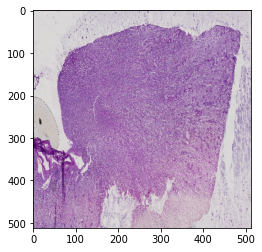

[afa5e8098] Image shape: (36800, 43780, 3)
[afa5e8098] Resized Image shape: (18400, 21890, 3)
Name               : /afa5e8098
Type               : zarr.core.Array
Data type          : uint8
Shape              : (18400, 21890, 3)
Chunk shape        : (1150, 2737, 1)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 1208328000 (1.1G)
No. bytes stored   : 973224241 (928.1M)
Storage ratio      : 1.2
Chunks initialized : 384/384



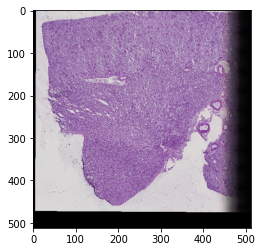

[1e2425f28] Image shape: (26780, 32220, 3)
[1e2425f28] Resized Image shape: (13390, 16110, 3)
Name               : /1e2425f28
Type               : zarr.core.Array
Data type          : uint8
Shape              : (13390, 16110, 3)
Chunk shape        : (837, 2014, 1)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 647138700 (617.2M)
No. bytes stored   : 520714410 (496.6M)
Storage ratio      : 1.2
Chunks initialized : 384/384



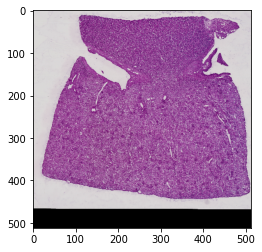

In [35]:
for idx in df_train['id']:
    # read + reduce image size to the half
    img = read_image(idx, path, scale=scale)
    # save
    g_out[idx] = img
    print(g_out[idx].info)
    
    # plot 
    plt.imshow(cv2.resize(img, dsize=(512, 512)))
    plt.show()

### 2.4.2 Masks and PDF(probability density function) 
- Tile slicing strategy  
  Knowing that the glomeruli are mainly found in the **cortex**, we should focus on this region during training.   
  Instead of preprocessing the images and saving them into fixed tiles, we randomly sample random tiles from the entire images **with a higher probability to sample tiles that contain glumeroli and cortex.**

-

#### 2.4.2.1 Anatomical Regional Masks 

- Convert anatomical structure segmentations from json to masks (.zarr files)
- Anatomical Regional masks map each pixel to cortex(1), medulla(2), or background(0).



In [20]:
# Settings
df_info = pd.read_csv(path/"HuBMAP-20-dataset_information.csv")
grp_anatomy = zarr.group(abspath_curr + '/working/anatomy') # path to store anatomical data (.zarr) 

image_file                                                    aa05346ff.tiff
width_pixels                                                           47340
height_pixels                                                          30720
anatomical_structures_segmention_file    aa05346ff-anatomical-structure.json
glomerulus_segmentation_file                                  aa05346ff.json
patient_number                                                         67347
race                                                                   White
ethnicity                                             Not Hispanic or Latino
sex                                                                   Female
age                                                                       58
weight_kilograms                                                          59
height_centimeters                                                       160
bmi_kg/m^2                                                                23

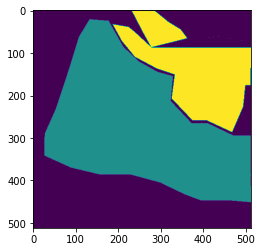

image_file                                                    afa5e8098.tiff
width_pixels                                                           43780
height_pixels                                                          36800
anatomical_structures_segmention_file    afa5e8098-anatomical-structure.json
glomerulus_segmentation_file                                  afa5e8098.json
patient_number                                                         67347
race                                                                   White
ethnicity                                             Not Hispanic or Latino
sex                                                                   Female
age                                                                       58
weight_kilograms                                                          59
height_centimeters                                                       160
bmi_kg/m^2                                                                23

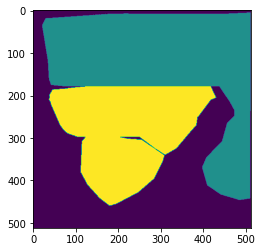

image_file                                                    54f2eec69.tiff
width_pixels                                                           22240
height_pixels                                                          30440
anatomical_structures_segmention_file    54f2eec69-anatomical-structure.json
glomerulus_segmentation_file                                  54f2eec69.json
patient_number                                                         67548
race                                               Black or African American
ethnicity                                             Not Hispanic or Latino
sex                                                                     Male
age                                                                       58
weight_kilograms                                                        79.9
height_centimeters                                                     190.5
bmi_kg/m^2                                                                22

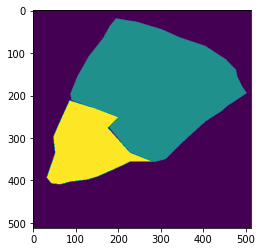

image_file                                                    d488c759a.tiff
width_pixels                                                           29020
height_pixels                                                          46660
anatomical_structures_segmention_file    d488c759a-anatomical-structure.json
glomerulus_segmentation_file                                  d488c759a.json
patient_number                                                         68138
race                                                                   White
ethnicity                                             Not Hispanic or Latino
sex                                                                   Female
age                                                                       66
weight_kilograms                                                        81.5
height_centimeters                                                     158.8
bmi_kg/m^2                                                              32.2

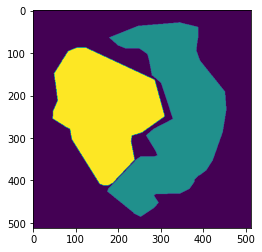

image_file                                                    1e2425f28.tiff
width_pixels                                                           32220
height_pixels                                                          26780
anatomical_structures_segmention_file    1e2425f28-anatomical-structure.json
glomerulus_segmentation_file                                  1e2425f28.json
patient_number                                                         63921
race                                                                   White
ethnicity                                             Not Hispanic or Latino
sex                                                                     Male
age                                                                       48
weight_kilograms                                                       131.5
height_centimeters                                                       193
bmi_kg/m^2                                                              35.3

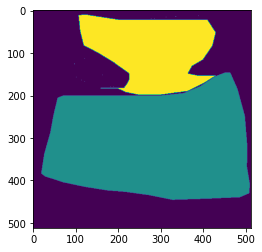

image_file                                                    e79de561c.tiff
width_pixels                                                           27020
height_pixels                                                          16180
anatomical_structures_segmention_file    e79de561c-anatomical-structure.json
glomerulus_segmentation_file                                  e79de561c.json
patient_number                                                         67026
race                                               Black or African American
ethnicity                                             Not Hispanic or Latino
sex                                                                     Male
age                                                                       53
weight_kilograms                                                          73
height_centimeters                                                       166
bmi_kg/m^2                                                              26.5

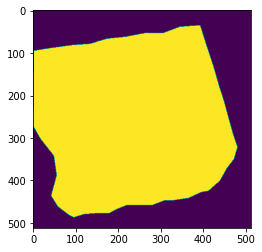

image_file                                                    c68fe75ea.tiff
width_pixels                                                           49780
height_pixels                                                          26840
anatomical_structures_segmention_file    c68fe75ea-anatomical-structure.json
glomerulus_segmentation_file                                  c68fe75ea.json
patient_number                                                         67112
race                                                                   White
ethnicity                                             Not Hispanic or Latino
sex                                                                     Male
age                                                                       56
weight_kilograms                                                        91.2
height_centimeters                                                     167.6
bmi_kg/m^2                                                              32.5

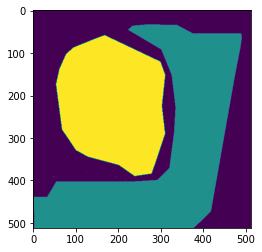

image_file                                                    095bf7a1f.tiff
width_pixels                                                           39000
height_pixels                                                          38160
anatomical_structures_segmention_file    095bf7a1f-anatomical-structure.json
glomerulus_segmentation_file                                  095bf7a1f.json
patient_number                                                         68250
race                                                                   White
ethnicity                                             Not Hispanic or Latino
sex                                                                   Female
age                                                                       44
weight_kilograms                                                        71.7
height_centimeters                                                       160
bmi_kg/m^2                                                                28

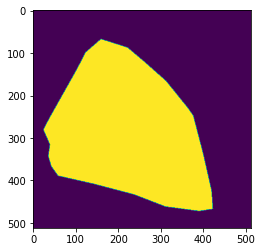

image_file                                                    26dc41664.tiff
width_pixels                                                           42360
height_pixels                                                          38160
anatomical_structures_segmention_file    26dc41664-anatomical-structure.json
glomerulus_segmentation_file                                  26dc41664.json
patient_number                                                         68304
race                                                                   White
ethnicity                                             Not Hispanic or Latino
sex                                                                   Female
age                                                                       66
weight_kilograms                                                        71.3
height_centimeters                                                     167.6
bmi_kg/m^2                                                              25.4

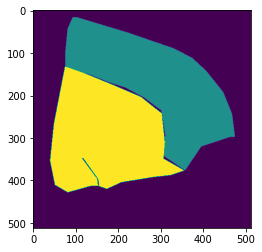

image_file                                                    57512b7f1.tiff
width_pixels                                                           43160
height_pixels                                                          33240
anatomical_structures_segmention_file    57512b7f1-anatomical-structure.json
glomerulus_segmentation_file                                  57512b7f1.json
patient_number                                                         68555
race                                                                   White
ethnicity                                             Not Hispanic or Latino
sex                                                                   Female
age                                                                       76
weight_kilograms                                                          93
height_centimeters                                                     157.4
bmi_kg/m^2                                                              37.5

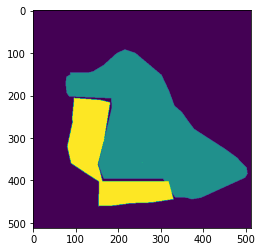

image_file                                                    4ef6695ce.tiff
width_pixels                                                           50680
height_pixels                                                          39960
anatomical_structures_segmention_file    4ef6695ce-anatomical-structure.json
glomerulus_segmentation_file                                  4ef6695ce.json
patient_number                                                         66999
race                                                                   White
ethnicity                                             Not Hispanic or Latino
sex                                                                     Male
age                                                                       56
weight_kilograms                                                        91.4
height_centimeters                                                     181.6
bmi_kg/m^2                                                              27.7

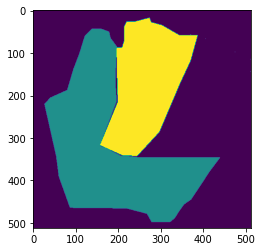

image_file                                                    aaa6a05cc.tiff
width_pixels                                                           13013
height_pixels                                                          18484
anatomical_structures_segmention_file    aaa6a05cc-anatomical-structure.json
glomerulus_segmentation_file                                  aaa6a05cc.json
patient_number                                                         65631
race                                                                   White
ethnicity                                             Not Hispanic or Latino
sex                                                                   Female
age                                                                       73
weight_kilograms                                                         NaN
height_centimeters                                                       NaN
bmi_kg/m^2                                                               NaN

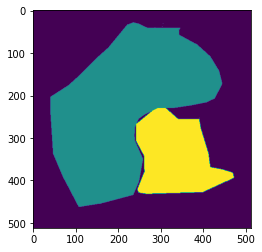

image_file                                                    b9a3865fc.tiff
width_pixels                                                           40429
height_pixels                                                          31295
anatomical_structures_segmention_file    b9a3865fc-anatomical-structure.json
glomerulus_segmentation_file                                  b9a3865fc.json
patient_number                                                         67347
race                                                                   White
ethnicity                                             Not Hispanic or Latino
sex                                                                   Female
age                                                                       58
weight_kilograms                                                          59
height_centimeters                                                       160
bmi_kg/m^2                                                                23

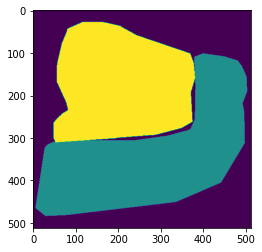

image_file                                                    cb2d976f4.tiff
width_pixels                                                           49548
height_pixels                                                          34940
anatomical_structures_segmention_file    cb2d976f4-anatomical-structure.json
glomerulus_segmentation_file                                  cb2d976f4.json
patient_number                                                         67548
race                                               Black or African American
ethnicity                                             Not Hispanic or Latino
sex                                                                     Male
age                                                                       58
weight_kilograms                                                        79.9
height_centimeters                                                     190.5
bmi_kg/m^2                                                                22

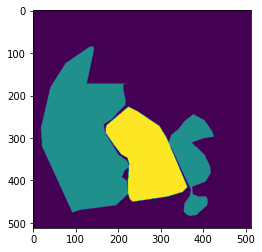

image_file                                                    b2dc8411c.tiff
width_pixels                                                           31262
height_pixels                                                          14844
anatomical_structures_segmention_file    b2dc8411c-anatomical-structure.json
glomerulus_segmentation_file                                  b2dc8411c.json
patient_number                                                         67026
race                                               Black or African American
ethnicity                                             Not Hispanic or Latino
sex                                                                     Male
age                                                                       53
weight_kilograms                                                          73
height_centimeters                                                       166
bmi_kg/m^2                                                              26.5

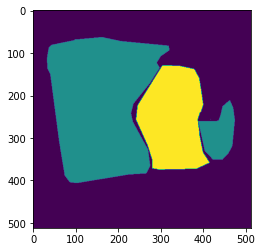

image_file                                                    2ec3f1bb9.tiff
width_pixels                                                           47723
height_pixels                                                          23990
anatomical_structures_segmention_file    2ec3f1bb9-anatomical-structure.json
glomerulus_segmentation_file                                  2ec3f1bb9.json
patient_number                                                         67112
race                                                                   White
ethnicity                                             Not Hispanic or Latino
sex                                                                     Male
age                                                                       56
weight_kilograms                                                        91.2
height_centimeters                                                     167.6
bmi_kg/m^2                                                              32.5

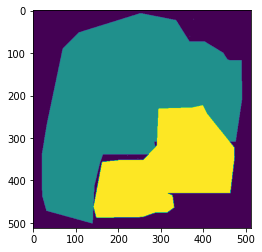

image_file                                                    0486052bb.tiff
width_pixels                                                           34937
height_pixels                                                          25784
anatomical_structures_segmention_file    0486052bb-anatomical-structure.json
glomerulus_segmentation_file                                  0486052bb.json
patient_number                                                         67177
race                                                                   White
ethnicity                                             Not Hispanic or Latino
sex                                                                     Male
age                                                                       31
weight_kilograms                                                       106.1
height_centimeters                                                     180.3
bmi_kg/m^2                                                              32.6

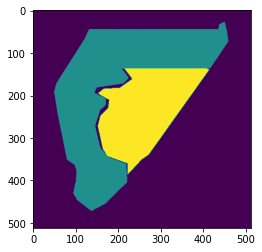

image_file                                                    3589adb90.tiff
width_pixels                                                           22165
height_pixels                                                          29433
anatomical_structures_segmention_file    3589adb90-anatomical-structure.json
glomerulus_segmentation_file                                  3589adb90.json
patient_number                                                         68304
race                                                                   White
ethnicity                                             Not Hispanic or Latino
sex                                                                   Female
age                                                                       66
weight_kilograms                                                        71.3
height_centimeters                                                     167.6
bmi_kg/m^2                                                              25.4

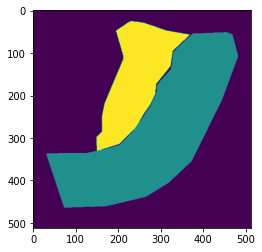

image_file                                                    2f6ecfcdf.tiff
width_pixels                                                           25794
height_pixels                                                          31278
anatomical_structures_segmention_file    2f6ecfcdf-anatomical-structure.json
glomerulus_segmentation_file                                  2f6ecfcdf.json
patient_number                                                         68555
race                                                                   White
ethnicity                                             Not Hispanic or Latino
sex                                                                   Female
age                                                                       76
weight_kilograms                                                          93
height_centimeters                                                     157.4
bmi_kg/m^2                                                              37.5

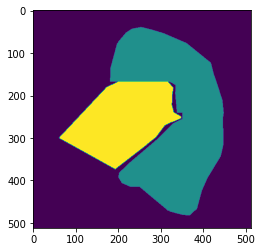

image_file                                                    8242609fa.tiff
width_pixels                                                           44066
height_pixels                                                          31299
anatomical_structures_segmention_file    8242609fa-anatomical-structure.json
glomerulus_segmentation_file                                  8242609fa.json
patient_number                                                         66999
race                                                                   White
ethnicity                                             Not Hispanic or Latino
sex                                                                     Male
age                                                                       56
weight_kilograms                                                        91.4
height_centimeters                                                     181.6
bmi_kg/m^2                                                              27.7

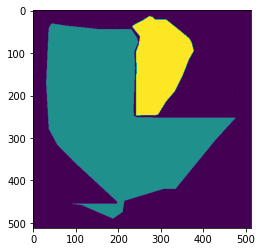

In [ ]:
# green: cortex, yellow: medulla
# Conversion
for _, row in df_info.iterrows():
    
    print(row)
    idx = Path(row.image_file).stem
    split = 'train' if idx in df_train['id'].values else 'test' # an image can be in train or test csv.
    
    # Open json
    with open(path/split/row.anatomical_structures_segmention_file) as json_file:
        data = json.load(json_file)  

    # Empty mask
    umat = cv2.UMat(np.zeros((row.height_pixels, row.width_pixels), dtype=np.int32))
        
    # Fill array
    for poly in data:
        coords = poly['geometry']['coordinates']
        value = 1 if poly['properties']['classification']['name']=='Cortex' else 2
        coords_cand = [coords] if len(coords)==1 else coords
        for coord in coords_cand:
            coords2 = cv2.UMat(np.array([[int(a),int(b)] for a,b in coord[0]]))
            umat = cv2.fillConvexPoly(umat, coords2, value)

    # Workaround RAM overflow
    grp_anatomy[idx] = umat.get()
    del umat
    gc.collect()
    grp_anatomy[idx] = grp_anatomy[idx][:].astype('uint8')
    #print(g_out[idx].info)
    
    plt.imshow(cv2.resize(grp_anatomy[idx][:], dsize=(512, 512)))
    plt.show()

2.4.2.2 Glomeruli Masks and PDF

- Create Glomeruli Masks from RLE
  (Glomerular = 1, else = 0)
- Create probability density function for efficient sampling form Glomerular masks and anatomical regional masks  
  **Final Weight Ratio of PDF**  
  Background: 0.01, Cortex: 0.5, Medulla: 0.25, Glomerular: 1


In [28]:
# Settings
scale = 2 
resize=512 # For pdf


# PDF Setting
weight_dict = {
    'fbr': 0.01,          # Background Weights
    'cortex_value': 0.5,  # Cortex Weights
    'medulla_value': 0.25 # Medulla Weights
}

# Output
root = zarr.group(abspath_curr +f'/kaggle/working/masks_scale{scale}')
g_msk, g_pdf = root.create_groups('labels', 'pdfs', overwrite=True)
g_pdf_mask = root.create_group('pdfs_mask', overwrite=True)

In [17]:
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1

    return img.reshape(shape).T


2f6ecfcdf with shape (31278, 25794)
Scaling to (12897, 15639)
Saving msk
Resizing PDF
Saving pdf cumsum


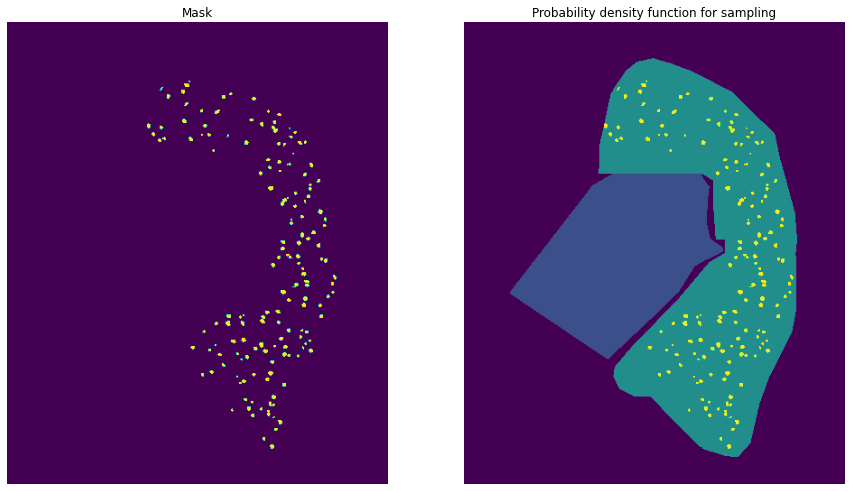

8242609fa with shape (31299, 44066)
Scaling to (22033, 15649)
Saving msk
Resizing PDF
Saving pdf cumsum


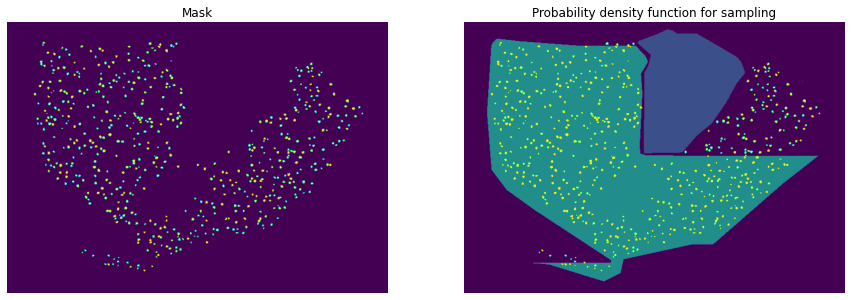

aaa6a05cc with shape (18484, 13013)
Scaling to (6506, 9242)
Saving msk
Resizing PDF
Saving pdf cumsum


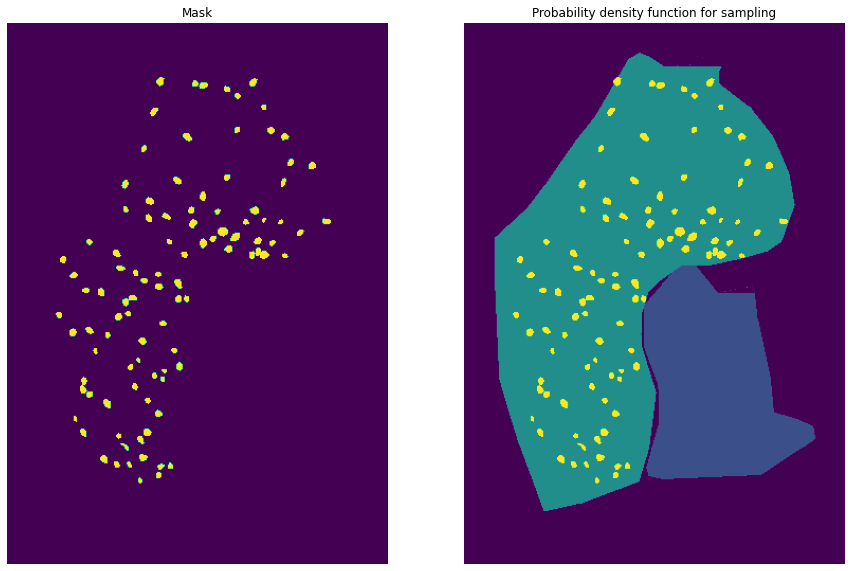

cb2d976f4 with shape (34940, 49548)
Scaling to (24774, 17470)
Saving msk
Resizing PDF
Saving pdf cumsum


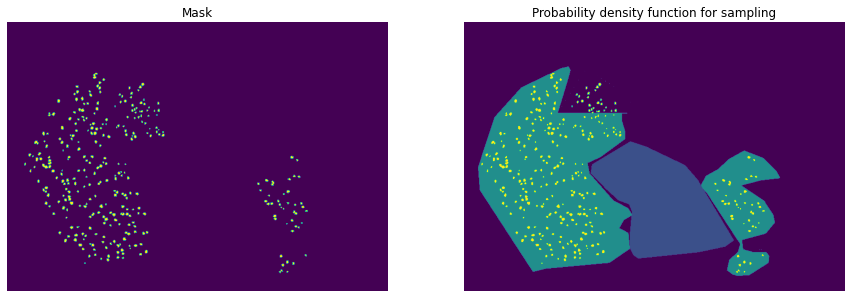

b9a3865fc with shape (31295, 40429)
Scaling to (20214, 15647)
Saving msk
Resizing PDF
Saving pdf cumsum


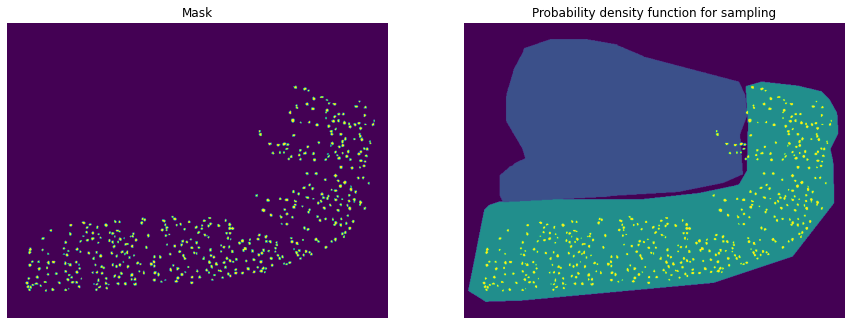

b2dc8411c with shape (14844, 31262)
Scaling to (15631, 7422)
Saving msk
Resizing PDF
Saving pdf cumsum


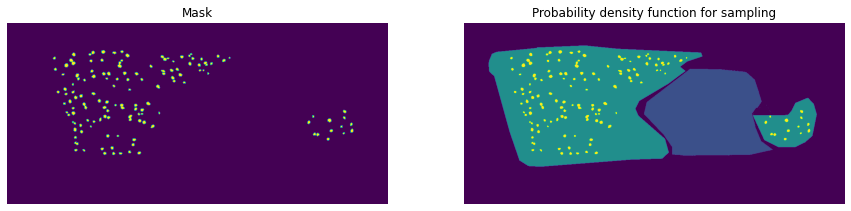

0486052bb with shape (25784, 34937)
Scaling to (17468, 12892)
Saving msk
Resizing PDF
Saving pdf cumsum


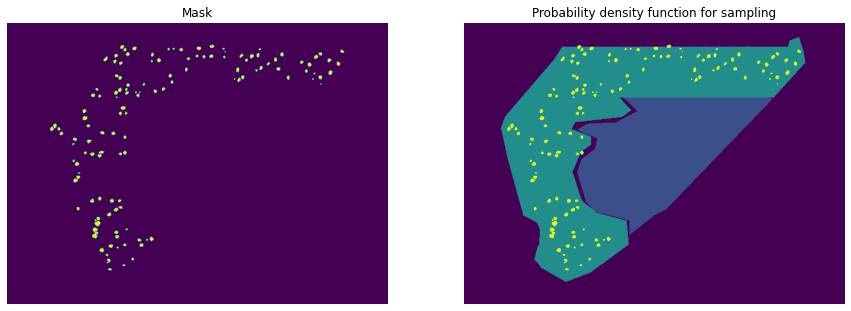

e79de561c with shape (16180, 27020)
Scaling to (13510, 8090)
Saving msk
Resizing PDF
Saving pdf cumsum


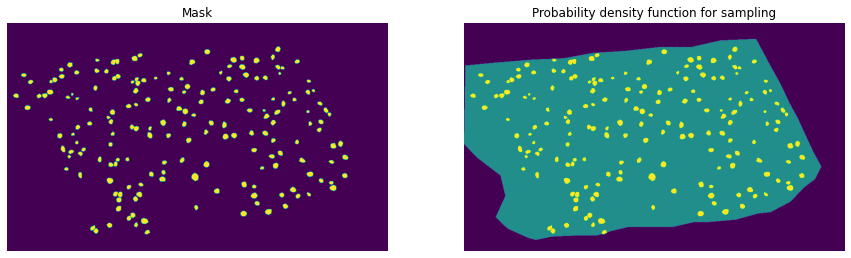

095bf7a1f with shape (38160, 39000)
Scaling to (19500, 19080)
Saving msk
Resizing PDF
Saving pdf cumsum


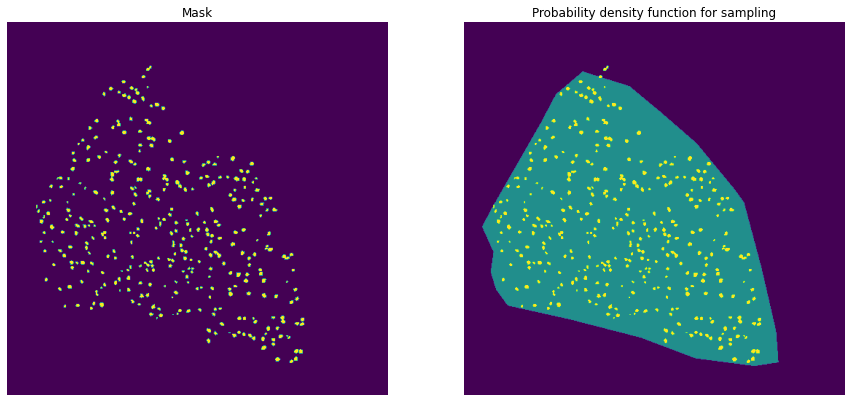

54f2eec69 with shape (30440, 22240)
Scaling to (11120, 15220)
Saving msk
Resizing PDF
Saving pdf cumsum


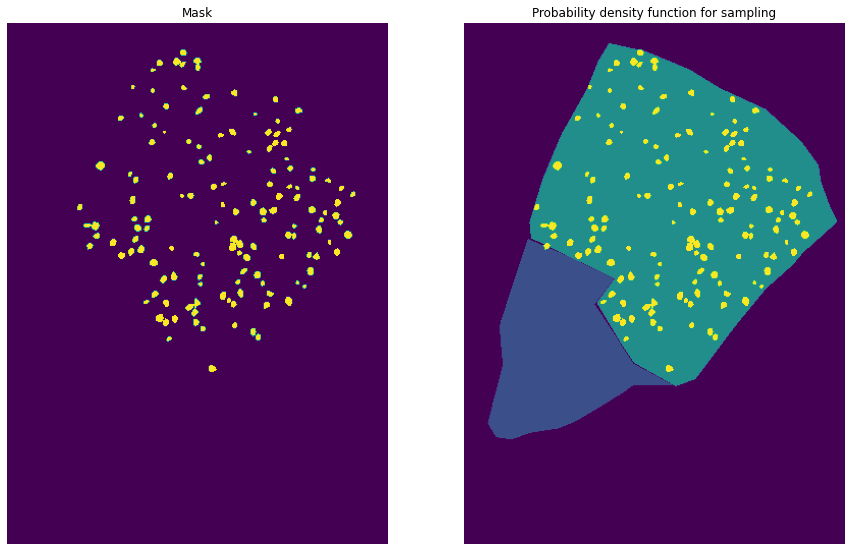

4ef6695ce with shape (39960, 50680)
Scaling to (25340, 19980)
Saving msk
Resizing PDF
Saving pdf cumsum


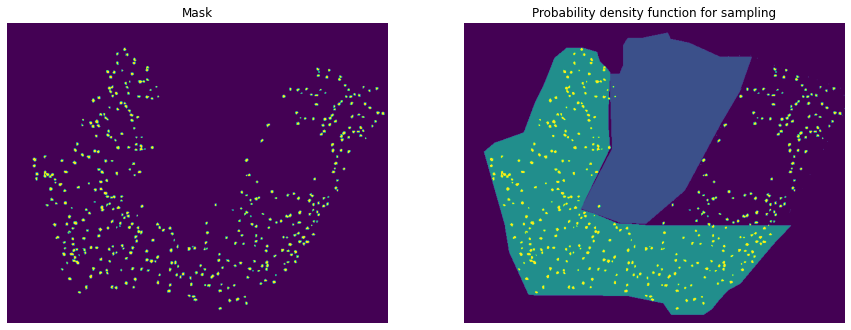

26dc41664 with shape (38160, 42360)
Scaling to (21180, 19080)
Saving msk
Resizing PDF
Saving pdf cumsum


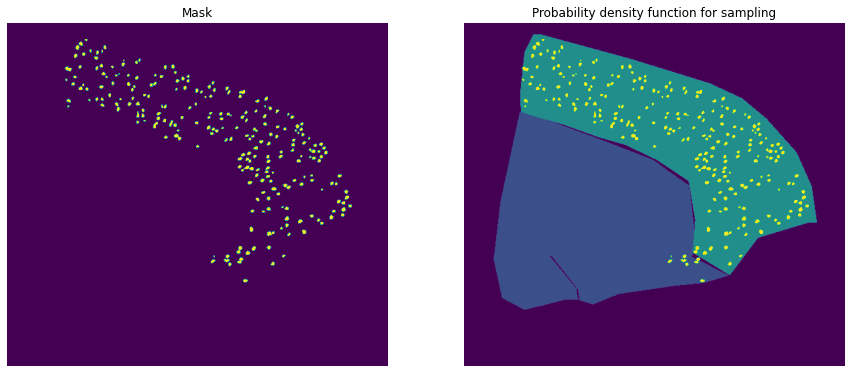

c68fe75ea with shape (26840, 49780)
Scaling to (24890, 13420)
Saving msk
Resizing PDF
Saving pdf cumsum


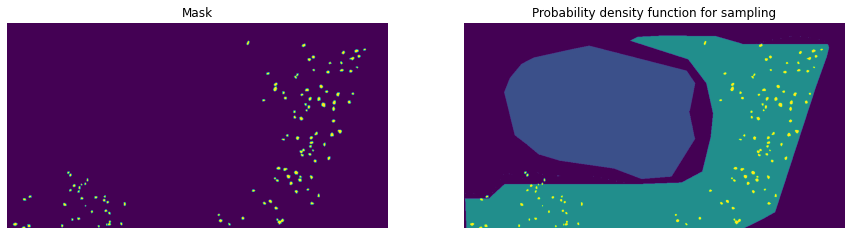

afa5e8098 with shape (36800, 43780)
Scaling to (21890, 18400)
Saving msk
Resizing PDF
Saving pdf cumsum


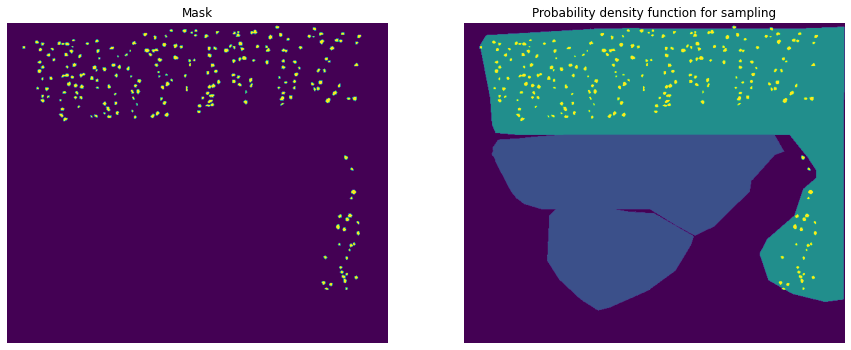

1e2425f28 with shape (26780, 32220)
Scaling to (16110, 13390)
Saving msk
Resizing PDF
Saving pdf cumsum


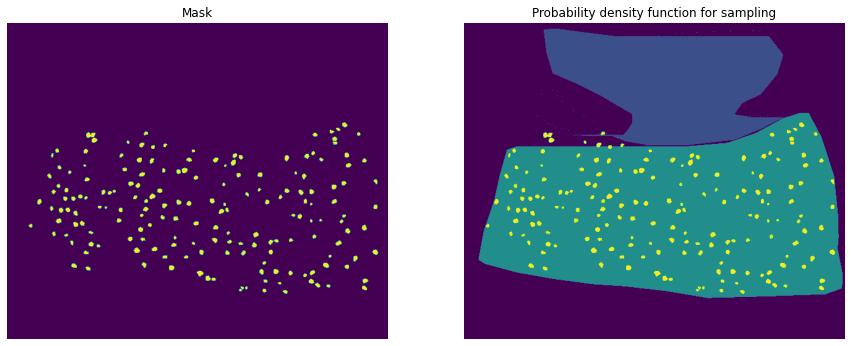

In [29]:
for _, row in df_train.iterrows():
    
    idx = row.id
    img_info = df_info[df_info.image_file==f'{idx}.tiff']
    shape = (img_info.height_pixels.values[0], img_info.width_pixels.values[0])
    print(idx, 'with shape', shape)
    
    # RLE to Glomerular Mask(numpy)
    msk = rle2mask(row.encoding, (shape[1], shape[0])).astype('uint8')
    
    # Plot
    fig, ax = plt.subplots(ncols=2, figsize=(15,15))
    resize_w = int((msk.shape[1]/msk.shape[0])*resize)
    ax[0].imshow(cv2.resize(msk, dsize=(resize_w, resize)))
    ax[0].set_title('Mask')
    ax[0].set_axis_off()
    
    # pdf 
    anatomy = grp_anatomy[idx][:]
    
    if scale:
        new_size = (msk.shape[1] // scale, msk.shape[0] // scale)
        print('Scaling to', new_size)
        msk = cv2.resize(msk, new_size)
        anatomy = cv2.resize(anatomy, new_size)
        
    anatomy = anatomy.astype('float16')
    # Background weight 0.01     
    anatomy[anatomy==0] = weight_dict['fbr']
    # Cortex weight 0.5
    anatomy[anatomy==1] = weight_dict['cortex_value']
    # Medulla weight = 0.25
    anatomy[anatomy>1] = weight_dict['medulla_value']
    # Glomerular weight = 1
    anatomy[msk>0] = 1
    
    # Save Glomerular Mask
    print('Saving msk')
    g_msk[idx] = msk
    del msk
    gc.collect()

    # Plot and Save PDF
    if resize:
        print('Resizing PDF')
        if anatomy.shape[0]>resize:
            resize_w = int((anatomy.shape[1]/anatomy.shape[0])*resize)
            anatomy = cv2.resize(anatomy[:].astype('float32'), dsize=(resize_w, resize))

    # save pdf mask
    
    g_pdf_mask[idx] = anatomy
    
    ax[1].imshow(anatomy)
    ax[1].set_title('Probability density function for sampling')
    ax[1].set_axis_off() 
            
    print('Saving pdf cumsum')
    g_pdf[idx] = np.cumsum(anatomy/np.sum(anatomy)) 

    plt.show()

### 2.5 Training

2.5.1 Methods and Parameters Settings

In [5]:
# monkey patch only refers to dynamic modifications of a class or module at runtime
# patch for deepflash2
# https://github.com/matjesg/deepflash2/blob/master/deepflash2/data.py#L283

@patch
def read_img(self:BaseDataset, file, *args, **kwargs):
    return zarr.open(str(file), mode='r')

@patch
def _name_fn(self:BaseDataset, g):
    "Name of preprocessed and compressed data."
    return f'{g}'

@patch
def apply(self:DeformationField, data, offset=(0, 0), pad=(0, 0), order=1):
    "Apply deformation field to image using interpolation"
    outshape = tuple(int(s - p) for (s, p) in zip(self.shape, pad))
    coords = [np.squeeze(d).astype('float32').reshape(*outshape) for d in self.get(offset, pad)]
    # Get slices to avoid loading all data (.zarr files)
    sl = []
    for i in range(len(coords)):
        cmin, cmax = int(coords[i].min()), int(coords[i].max())
        dmax = data.shape[i]
        if cmin<0: 
            cmax = max(-cmin, cmax)
            cmin = 0 
        elif cmax>dmax:
            cmin = min(cmin, 2*dmax-cmax)
            cmax = dmax
            coords[i] -= cmin
        else: coords[i] -= cmin
        sl.append(slice(cmin, cmax))    
    if len(data.shape) == len(self.shape) + 1:
        tile = np.empty((*outshape, data.shape[-1]))
        for c in range(data.shape[-1]):
            # Adding divide
            tile[..., c] = cv2.remap(data[sl[0],sl[1], c]/255, coords[1],coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    else:
        tile = cv2.remap(data[sl[0], sl[1]], coords[1], coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    return tile

In [6]:
# parameters
class CONFIG():
    
    # data paths
    data_path = Path(abspath_curr+"/input") 
    data_path_zarr = Path(abspath_curr+'/working/zarr_scale2')
    mask_preproc_dir = abspath_curr+'/working/masks_scale2'
    
    # deepflash2 dataset
    scale = 1.5 # data is already downscaled to 2, so absulute downscale is 3
    tile_shape = (512, 512)
    padding = (0,0) # Border overlap for prediction
    n_jobs = 1
    sample_mult = 100 # Sample 100 tiles from each image, per epoch
    val_length = 500 # Randomly sample 500 validation tiles
    stats = np.array([0.61561477, 0.5179343 , 0.64067212]), np.array([0.2915353 , 0.31549066, 0.28647661])
    
    # deepflash2 augmentation options
    zoom_sigma = 0.1
    flip = True
    max_rotation = 360
    deformation_grid_size = (150,150)
    deformation_magnitude = (10,10)
    

    # pytorch model (segmentation_models_pytorch)
    encoder_name = "efficientnet-b4"# backbone model
    encoder_weights = 'imagenet' # weight initialization
    in_channels = 3
    classes = 2
    
    # fastai Learner 
    mixed_precision_training = True
    batch_size = 16
    weight_decay = 0.01
    loss_func = CrossEntropyLossFlat(axis=1) # loss functioin
    metrics = [Iou(), Dice_f1()] 
    optimizer = ranger
    max_learning_rate = 1e-3
    epochs = 12
    
cfg = CONFIG()

In [7]:
# Albumentations augmentations
tfms = alb.OneOf([ # Select one of transforms to apply.
    alb.HueSaturationValue(10,15,10), # Randomly change hue, saturation and value of the input image.
    alb.CLAHE(clip_limit=2), # Apply Contrast Limited Adaptive Histogram Equalization to the input image.
    alb.RandomBrightnessContrast(), # Randomly change brightness and contrast of the input image.
    ], p=0.3) # probability of applying the transform. 

2.5.2 Data Split

In [8]:
files = [x for x in cfg.data_path_zarr.iterdir() if x.is_dir() if not x.name.startswith('.')] # file paths list
label_fn = lambda o: o

In [9]:
# Data(path) Split
# there are total 10 files with mask data

train_files = files[:8] # 8 train files 
valid_files = files[8:10] # 2 validation files
test_files = files[10:] # 5 test files

In [10]:
# Datasets
ds_kwargs = {
    'tile_shape':cfg.tile_shape,
    'padding':cfg.padding,
    'scale': cfg.scale,
    'n_jobs': cfg.n_jobs, 
    'preproc_dir': cfg.mask_preproc_dir, 
    'val_length':cfg.val_length, 
    'sample_mult':cfg.sample_mult,
    'loss_weights':False,
    'zoom_sigma': cfg.zoom_sigma,
    'flip' : cfg.flip,
    'max_rotation': cfg.max_rotation,
    'deformation_grid_size' : cfg.deformation_grid_size,
    'deformation_magnitude' : cfg.deformation_magnitude,
    'albumentations_tfms': tfms
}

train_ds = RandomTileDataset(train_files, label_fn=label_fn, **ds_kwargs) # Pytorch Dataset that creates random tiles with augmentations from the input images.
valid_ds = TileDataset(valid_files, label_fn=label_fn, **ds_kwargs, is_zarr=True) # Pytorch Dataset that creates random tiles for validation and prediction on new data.

Using preprocessed masks from /content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/final/working/masks_scale2
Using preprocessed masks from /content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/final/working/masks_scale2


2.5.3 Model 

First Segmentation Model
- Architecture : Unet
- Encoder : efficientnet b4

In [ ]:
# load pretrained Model
model = smp.Unet(encoder_name=cfg.encoder_name, 
                 encoder_weights=cfg.encoder_weights, 
                 in_channels=cfg.in_channels, 
                 classes=cfg.classes)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


In [ ]:
# dataloaders
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=cfg.batch_size, after_batch=Normalize.from_stats(*cfg.stats),num_workers=4)
# cpu or gpu
if torch.cuda.is_available(): dls.cuda(), model.cuda()
# callbacks
cbs = [SaveModelCallback(monitor='dice_f1'), EarlyStoppingCallback, ReduceLROnPlateau, ElasticDeformCallback]
# compile
learn = Learner(dls, model, metrics=cfg.metrics, wd=cfg.weight_decay, loss_func=cfg.loss_func, opt_func=ranger, cbs=cbs) # metric : [Iou(), Dice_f1()], loss function: ranger,  
if cfg.mixed_precision_training: learn.to_fp16()  

Better model found at epoch 0 with dice_f1 value: 0.05152590258238062.
Better model found at epoch 1 with dice_f1 value: 0.6995555634668211.
Better model found at epoch 2 with dice_f1 value: 0.8713165244517102.
Better model found at epoch 3 with dice_f1 value: 0.8927240781898599.
Better model found at epoch 5 with dice_f1 value: 0.9082763747914506.
Better model found at epoch 6 with dice_f1 value: 0.9163107764849642.
No improvement since epoch 5: early stopping


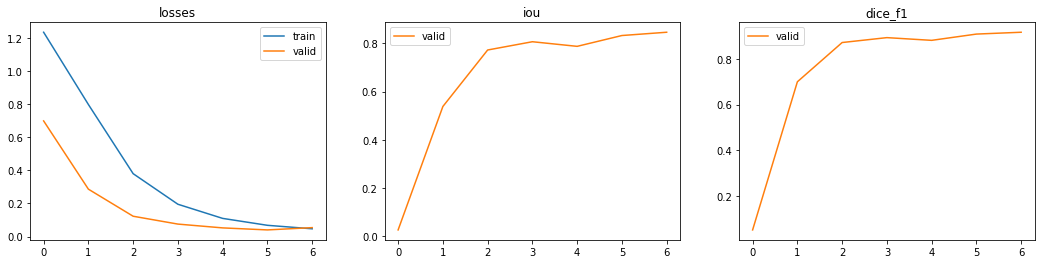

In [ ]:
# Fit
learn.fit_one_cycle(cfg.epochs, lr_max=cfg.max_learning_rate)
learn.recorder.plot_metrics()

In [ ]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/model/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
# Save Model
state = {'model': learn.model.state_dict(), 'stats':cfg.stats}
torch.save(state, f'{abspath_curr}/result/model/unet_{cfg.encoder_name}.pth',pickle_protocol=2, _use_new_zipfile_serialization=False)

### 2.6 Testing

In [11]:
def load_model_weights(model, file, strict=True):
    state = torch.load(file, map_location='cpu')
    stats = state['stats']
    model_state = state['model']
    model.load_state_dict(model_state, strict=strict)
    return model, stats


In [12]:
# https://matjesg.github.io/deepflash2/data.html#BaseDataset
# Handling of different input shapes
@patch
def read_img(self:BaseDataset, *args, **kwargs):
    image = tifffile.imread(args[0])
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    elif image.shape[0] == 3:
        image = image.transpose(1, 2, 0)
    return image

In [13]:
class CONFIG():
    
    # data paths

    data_path = Path(abspath_curr+"/input") 
    model_file = abspath_curr + '/result/model/unet_efficientnet-b4.pth'
    
    # deepflash2 dataset (https://matjesg.github.io/deepflash2/data.html#TileDataset)
    scale = 3 # zoom facor (zoom out)
    tile_shape = (512, 512)
    padding = (100,100) # Border overlap for prediction

    # pytorch model (https://github.com/qubvel/segmentation_models.pytorch)
    encoder_name = "efficientnet-b4"
    encoder_weights = None
    in_channels = 3
    classes = 2
    
    # dataloader 
    batch_size = 16
    
    # prediction threshold
    threshold = 0.4
    
cfg = CONFIG()

In [14]:
# Model (see https://github.com/qubvel/segmentation_models.pytorch)
model = smp.Unet(encoder_name=cfg.encoder_name, 
                 encoder_weights=cfg.encoder_weights, 
                 in_channels=cfg.in_channels, 
                 classes=cfg.classes)
model, stats = load_model_weights(model, cfg.model_file)
batch_tfms = [Normalize.from_stats(*stats)]

In [15]:
path = Path(abspath_curr+"/input") # basic path to data
df_train = pd.read_csv(path/"train.csv") # contains ids of images
df_test = df_train[10:]

In [31]:
#path = Path(abspath_curr+"/input") # basic path to data
#g_pdf_mask = zarr.open_group('pdfs_mask', overwrite=True)

###### File 4ef6695ce ######


Shape: (39960, 50680, 3)
Prediction


0.4
Plotting


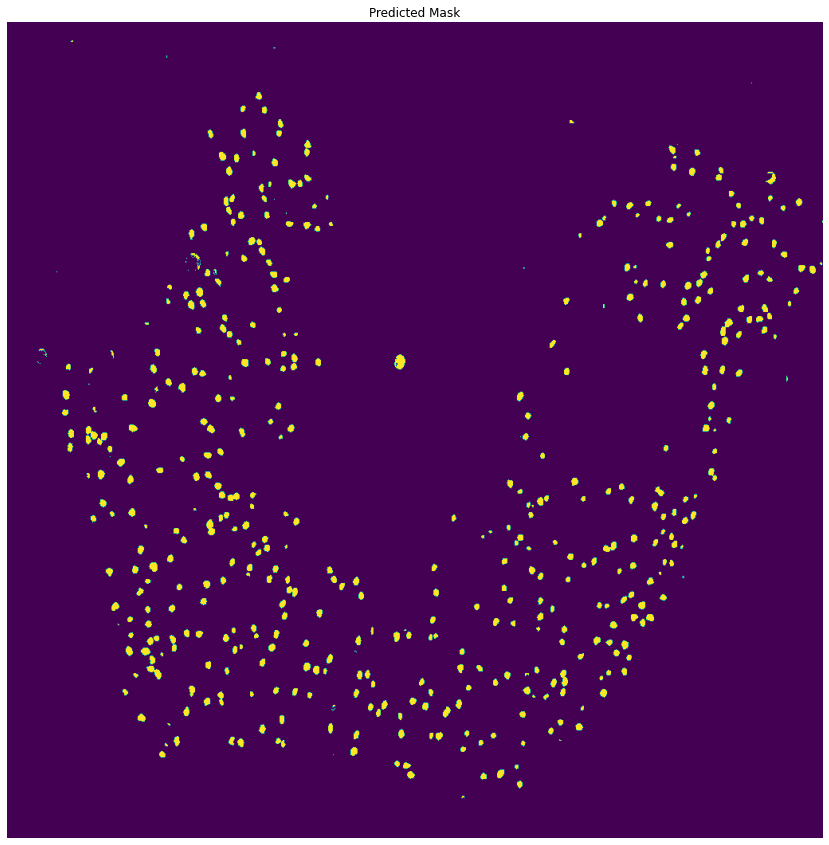

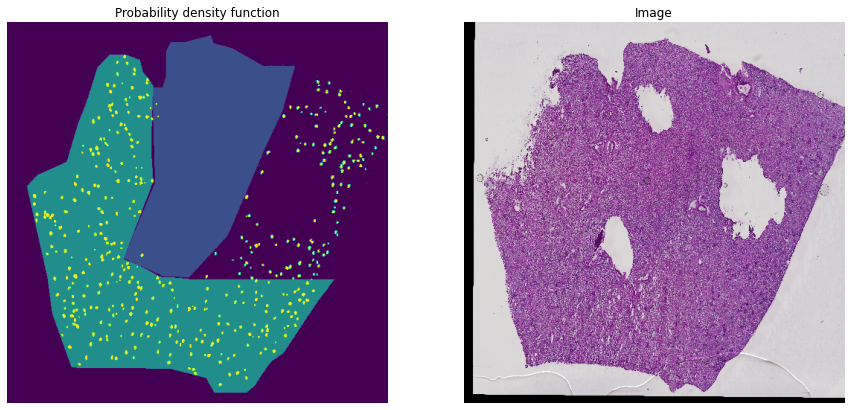

###### File 26dc41664 ######


Shape: (38160, 42360, 3)
Prediction


0.4
Plotting


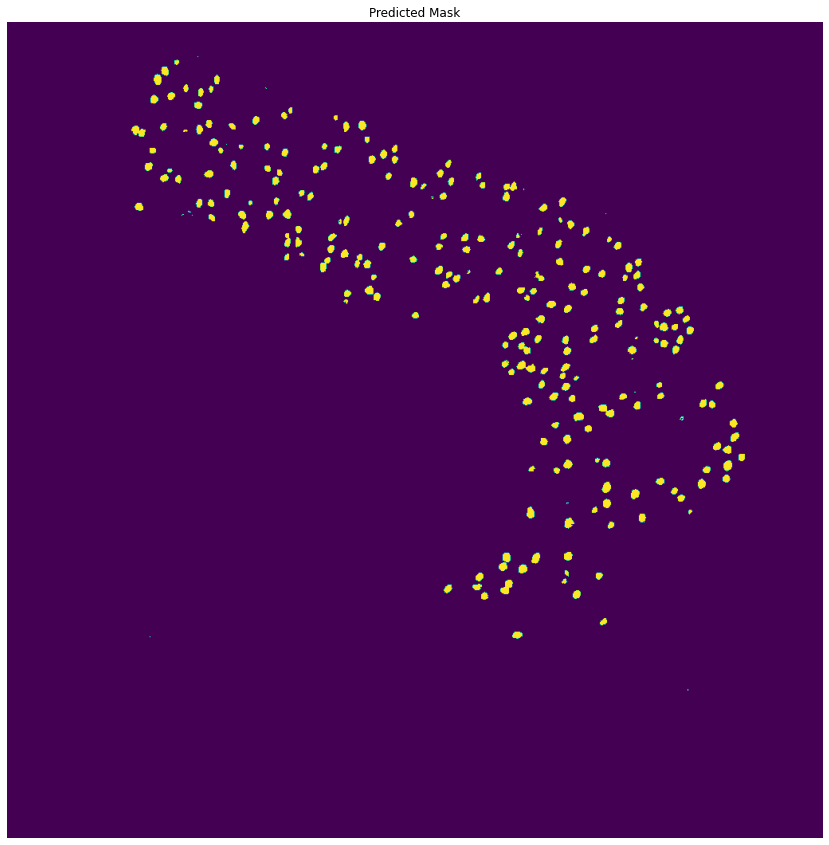

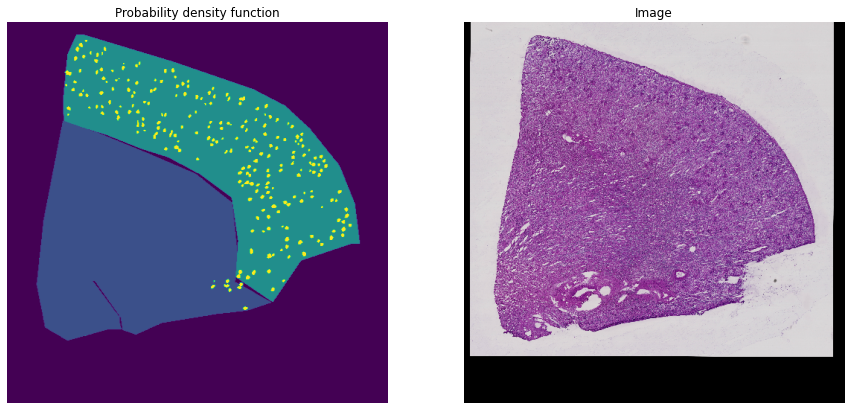

###### File c68fe75ea ######


Shape: (26840, 49780, 3)
Prediction


0.4
Plotting


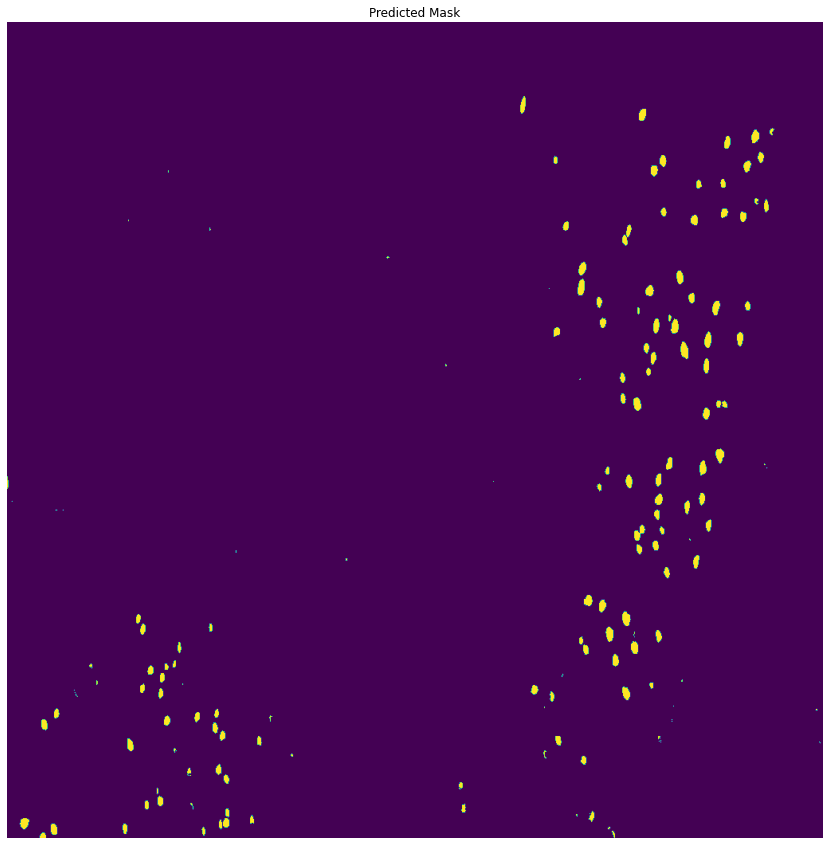

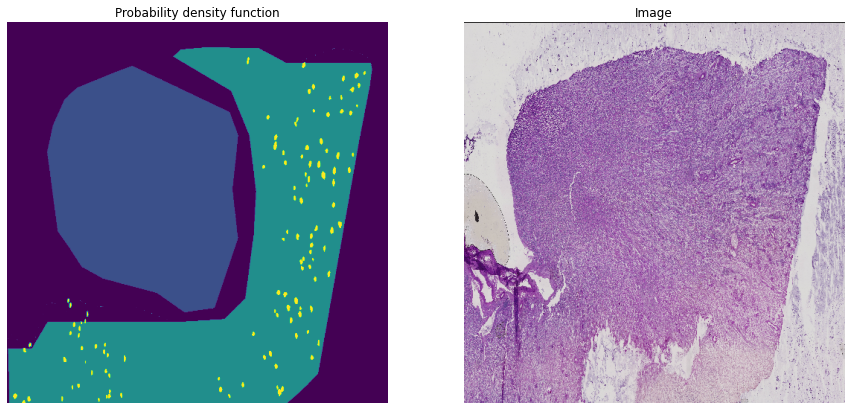

###### File afa5e8098 ######


Shape: (36800, 43780, 3)
Prediction


0.4
Plotting


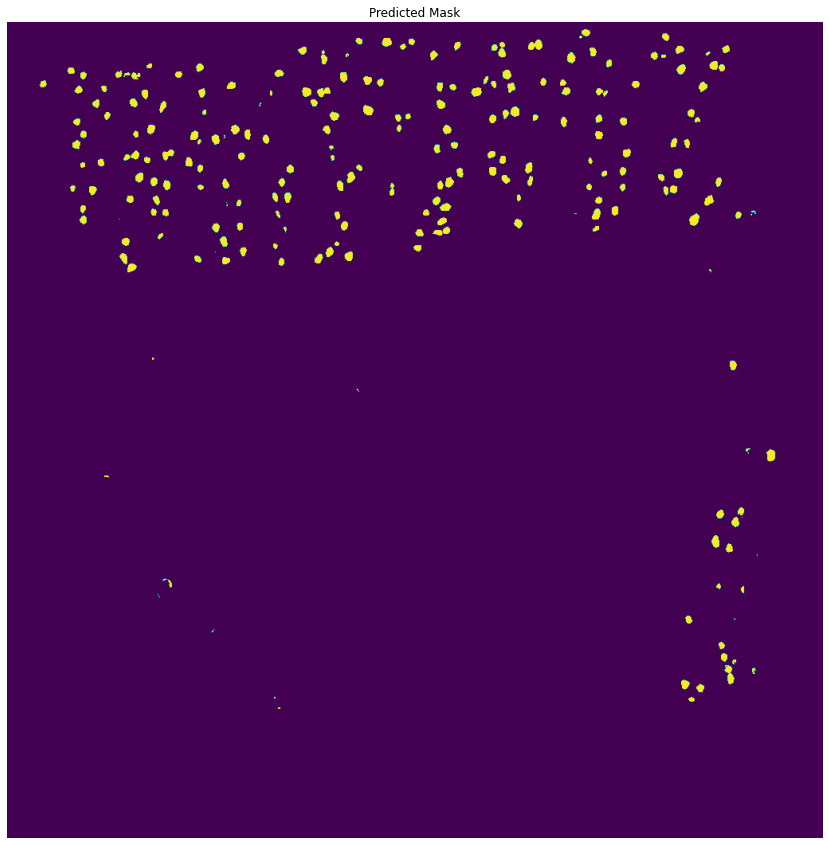

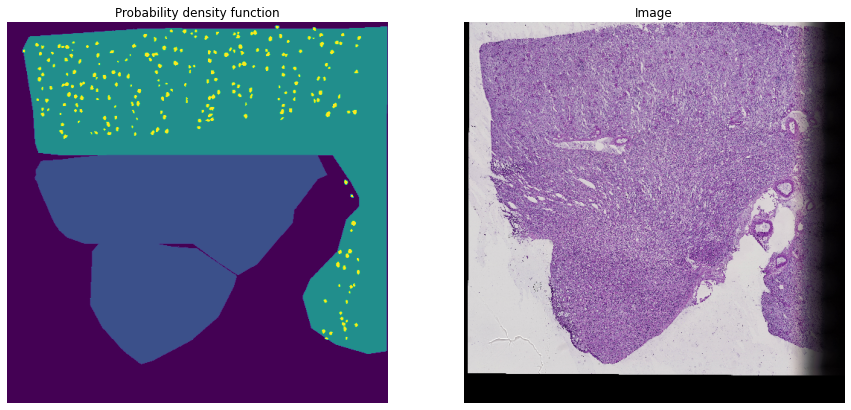

###### File 1e2425f28 ######


Shape: (26780, 32220, 3)
Prediction


0.4
Plotting


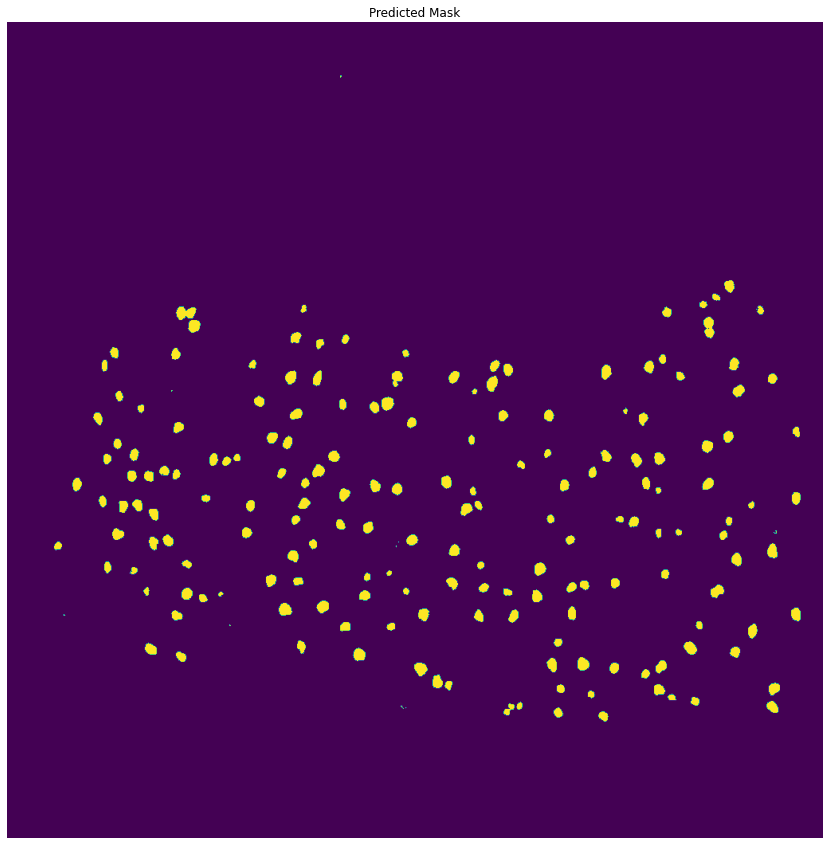

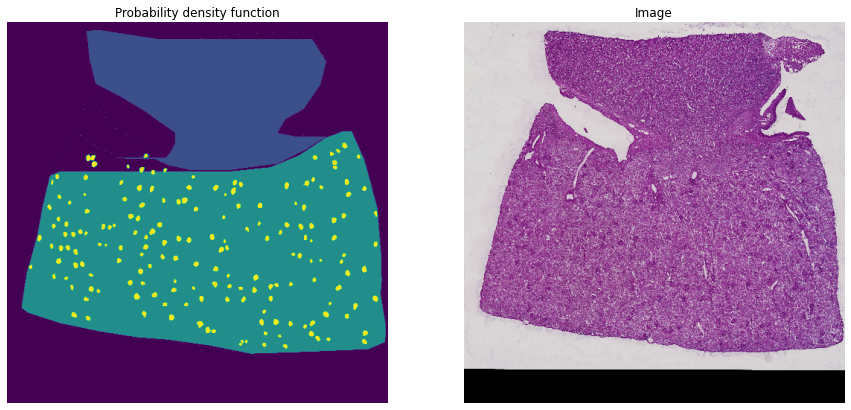

In [38]:
names,preds = [],[]
arr_preds = []
imgs = zarr.open_group(abspath_curr + f'/working/zarr_scale{scale}') 

for _, row in df_test.iterrows():
    idx = row.id
    print(f'###### File {idx} ######')
    f = cfg.data_path/'train'/f'{idx}.tiff'
    
    # Create deepflash2 dataset (including tiling and file conversion)
    ds = TileDataset([f], scale=cfg.scale, tile_shape=cfg.tile_shape, padding=cfg.padding)
    shape = ds.data[f.name].shape
    print('Shape:', shape)
    
    # Create fastai dataloader and learner
    dls = DataLoaders.from_dsets(ds, batch_size=cfg.batch_size, after_batch=batch_tfms, shuffle=False, drop_last=False)
    if torch.cuda.is_available(): dls.cuda(), model.cuda()
    learn = Learner(dls, model, loss_func='')
    
    # Predict tiles, see https://matjesg.github.io/deepflash2/learner.html#Learner.predict_tiles
    print('Prediction')
    res = learn.predict_tiles(dl=dls.train, path='/predict/', use_tta=False, uncertainty_estimates=False)
    
    # Load mask from softmax prediction > threshold
    th = 0.2 if idx=='d488c759a' else cfg.threshold
    print(th)
    msk = (res[0][f.name][..., 1]>th).astype(np.uint8)
    arr_preds.append(msk)
    
    
    # Plot Result
    print('Plotting')
    # predicted mask
    fig, ax = plt.subplots(figsize=(15,15))
    ax.imshow(cv2.resize(res[1][f.name][:].astype(np.uint8), (1024, 1024)))
    ax.set_title('Predicted Mask')
    ax.set_axis_off()
    plt.show()
    
    
    
    ### pdf
    fig, ax = plt.subplots(ncols=2, figsize=(15,15))
    pdf = g_pdf_mask[idx][:]
    pdf = cv2.resize(pdf[:].astype('float32'), dsize=(512, 512))

    ax[0].imshow(pdf)
    ax[0].set_title('Probability density function')
    ax[0].set_axis_off() 


    ### real image
    img = imgs[idx]
    img = cv2.resize(img[:], dsize=(512, 512))

    ax[1].imshow(img)
    ax[1].set_title('Image')
    ax[1].set_axis_off() 

    plt.show()



In [ ]:
real_masks = zarr.open_group(abspath_curr + f'/working/masks_scale2/labels')
dice_sum = 0

for i, row in df_test.iterrows():
   test_i = i-10
   idx = row.id
   print(f'###### File {idx} ######')

   real_mask = real_masks[idx]
   real_mask_shape = real_mask.shape

   pred_mask = arr_preds[test_i]
   pred_mask = cv2.resize(pred_mask, (real_mask_shape[1], real_mask_shape[0]))
   
   inter = (real_mask[:] * pred_mask[:]).sum().item()
   union = (real_mask[:] + pred_mask[:]).sum().item()
   cur_dice =  2 * inter / union   
   print("Dice for this image is: ",cur_dice)
   dice_sum += 2 * inter / union   

dice_sum/len(df_test)

###### File 4ef6695ce ######
Dice for this image is:  0.920546939705998
###### File 26dc41664 ######
Dice for this image is:  0.9231637901346447
###### File c68fe75ea ######
Dice for this image is:  0.858942180892887
###### File afa5e8098 ######
Dice for this image is:  0.8966759487417043
###### File 1e2425f28 ######
Dice for this image is:  0.930499331135845


0.9059656381222159

Second Model  
Architecture : Unet
Backbone : Resnet34

In [ ]:
# monkey patch only refers to dynamic modifications of a class or module at runtime
# patch for deepflash2
# https://github.com/matjesg/deepflash2/blob/master/deepflash2/data.py#L283

@patch
def read_img(self:BaseDataset, file, *args, **kwargs):
    return zarr.open(str(file), mode='r')

@patch
def _name_fn(self:BaseDataset, g):
    "Name of preprocessed and compressed data."
    return f'{g}'

@patch
def apply(self:DeformationField, data, offset=(0, 0), pad=(0, 0), order=1):
    "Apply deformation field to image using interpolation"
    outshape = tuple(int(s - p) for (s, p) in zip(self.shape, pad))
    coords = [np.squeeze(d).astype('float32').reshape(*outshape) for d in self.get(offset, pad)]
    # Get slices to avoid loading all data (.zarr files)
    sl = []
    for i in range(len(coords)):
        cmin, cmax = int(coords[i].min()), int(coords[i].max())
        dmax = data.shape[i]
        if cmin<0: 
            cmax = max(-cmin, cmax)
            cmin = 0 
        elif cmax>dmax:
            cmin = min(cmin, 2*dmax-cmax)
            cmax = dmax
            coords[i] -= cmin
        else: coords[i] -= cmin
        sl.append(slice(cmin, cmax))    
    if len(data.shape) == len(self.shape) + 1:
        tile = np.empty((*outshape, data.shape[-1]))
        for c in range(data.shape[-1]):
            # Adding divide
            tile[..., c] = cv2.remap(data[sl[0],sl[1], c]/255, coords[1],coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    else:
        tile = cv2.remap(data[sl[0], sl[1]], coords[1], coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    return tile
  
# parameters
class CONFIG():
    
    # data paths
    data_path = Path(abspath_curr+"/input") 
    data_path_zarr = Path(abspath_curr+'/working/zarr_scale2')
    mask_preproc_dir = abspath_curr+'/working/masks_scale2'
    
    # deepflash2 dataset
    scale = 1.5 # data is already downscaled to 2, so absulute downscale is 3
    tile_shape = (512, 512)
    padding = (0,0) # Border overlap for prediction
    n_jobs = 1
    sample_mult = 100 # Sample 100 tiles from each image, per epoch
    val_length = 500 # Randomly sample 500 validation tiles
    stats = np.array([0.61561477, 0.5179343 , 0.64067212]), np.array([0.2915353 , 0.31549066, 0.28647661])
    
    # deepflash2 augmentation options
    zoom_sigma = 0.1
    flip = True
    max_rotation = 360
    deformation_grid_size = (150,150)
    deformation_magnitude = (10,10)
    

    # pytorch model (segmentation_models_pytorch)
    encoder_name = "resnet34" # backbone model
    encoder_weights = 'imagenet' # weight initialization
    in_channels = 3
    classes = 2
    
    # fastai Learner 
    mixed_precision_training = True
    batch_size = 16
    weight_decay = 0.01
    loss_func = CrossEntropyLossFlat(axis=1) # loss functioin
    metrics = [Iou(), Dice_f1()] 
    optimizer = ranger
    max_learning_rate = 1e-3
    epochs = 12
    
cfg = CONFIG()

In [ ]:
# load pretrained Model
model = smp.Unet(encoder_name=cfg.encoder_name, 
                 encoder_weights=cfg.encoder_weights, 
                 in_channels=cfg.in_channels, 
                 classes=cfg.classes)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
# dataloaders
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=cfg.batch_size, after_batch=Normalize.from_stats(*cfg.stats),num_workers=4)
# cpu or gpu
if torch.cuda.is_available(): dls.cuda(), model.cuda()
# callbacks
cbs = [SaveModelCallback(monitor='dice_f1'), EarlyStoppingCallback, ReduceLROnPlateau, ElasticDeformCallback]
# compile
learn = Learner(dls, model, metrics=cfg.metrics, wd=cfg.weight_decay, loss_func=cfg.loss_func, opt_func=ranger, cbs=cbs)
if cfg.mixed_precision_training: learn.to_fp16()  

Better model found at epoch 0 with dice_f1 value: 0.14919171002584453.
Better model found at epoch 1 with dice_f1 value: 0.7797444141440069.
Better model found at epoch 2 with dice_f1 value: 0.7936360072649167.
Better model found at epoch 4 with dice_f1 value: 0.8805342973649275.
Better model found at epoch 5 with dice_f1 value: 0.9016376211484494.
No improvement since epoch 5: early stopping


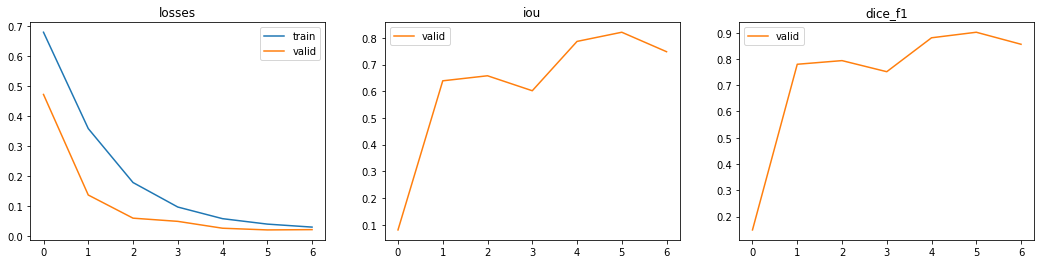

In [ ]:
# Fit
learn.fit_one_cycle(cfg.epochs, lr_max=cfg.max_learning_rate)
learn.recorder.plot_metrics()

In [ ]:
# Save Model
state = {'model': learn.model.state_dict(), 'stats':cfg.stats}
torch.save(state, f'{abspath_curr}/result/model/unet_{cfg.encoder_name}.pth',pickle_protocol=2, _use_new_zipfile_serialization=False)

###### File 4ef6695ce ######


Shape: (39960, 50680, 3)
Prediction


0.4
Rezising
Plotting


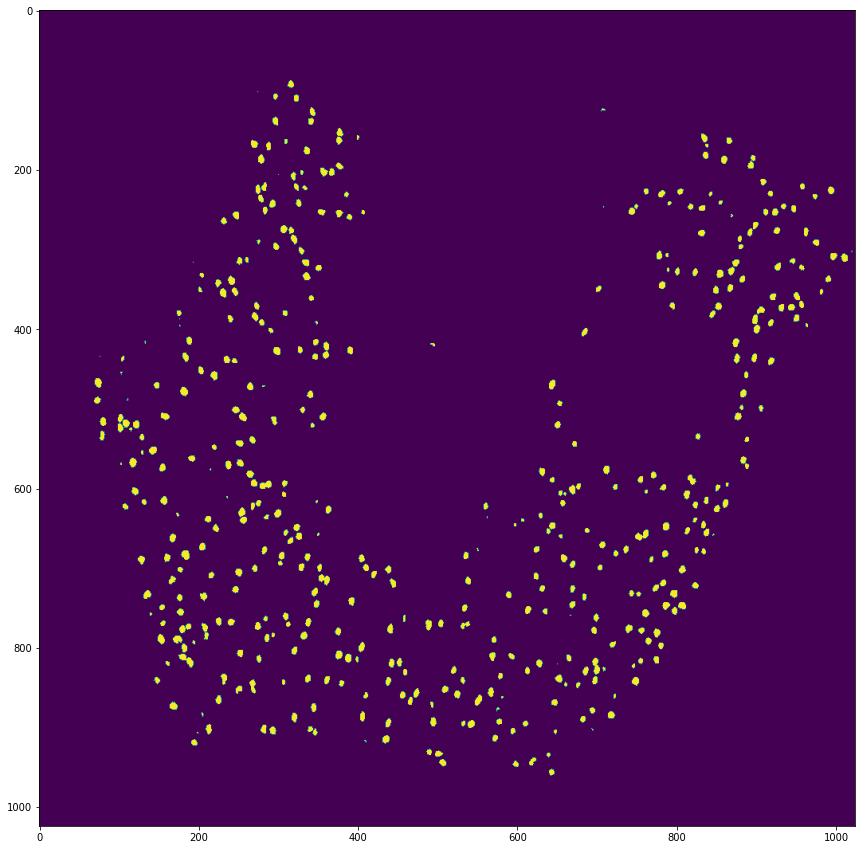

###### File 26dc41664 ######


Shape: (38160, 42360, 3)
Prediction


0.4
Rezising
Plotting


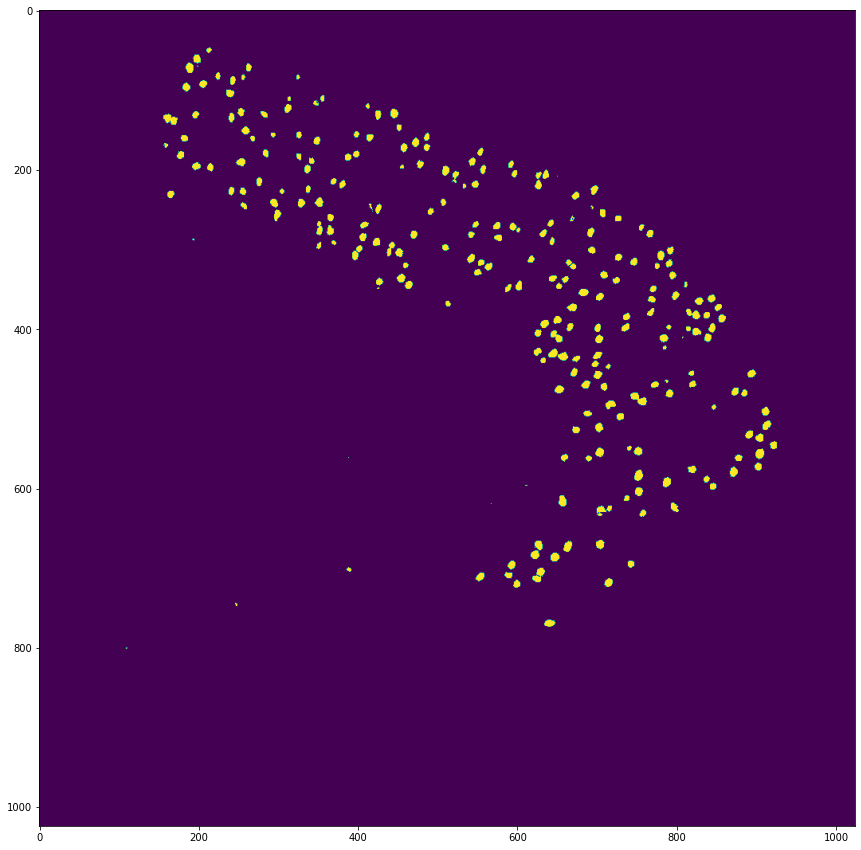

###### File c68fe75ea ######


Shape: (26840, 49780, 3)
Prediction


0.4
Rezising
Plotting


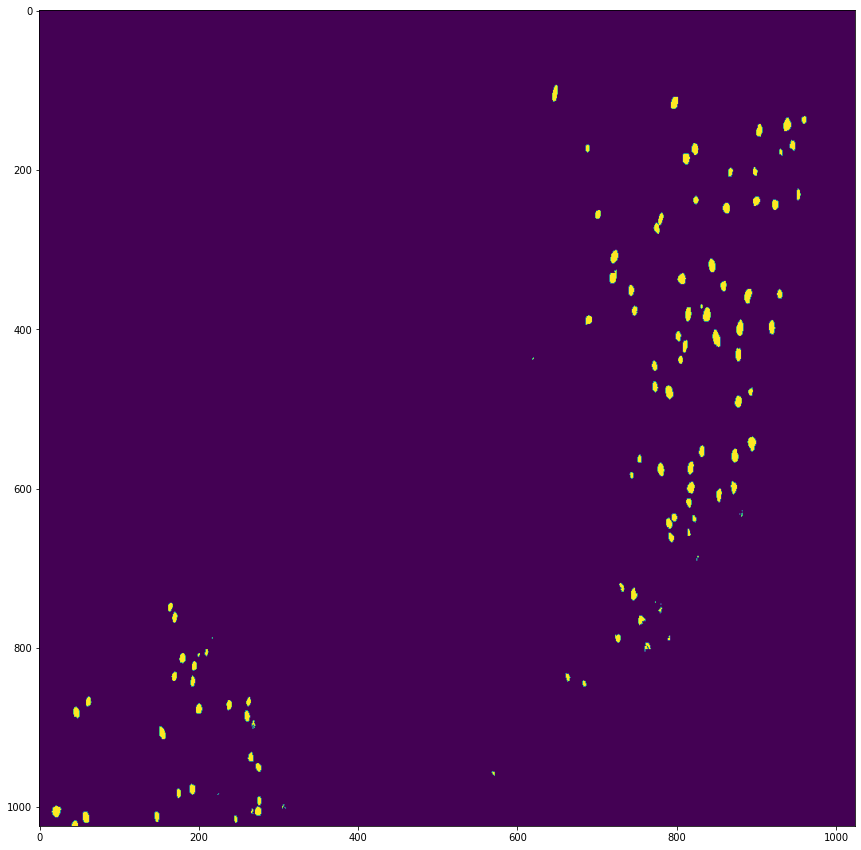

###### File afa5e8098 ######


Shape: (36800, 43780, 3)
Prediction


0.4
Rezising
Plotting


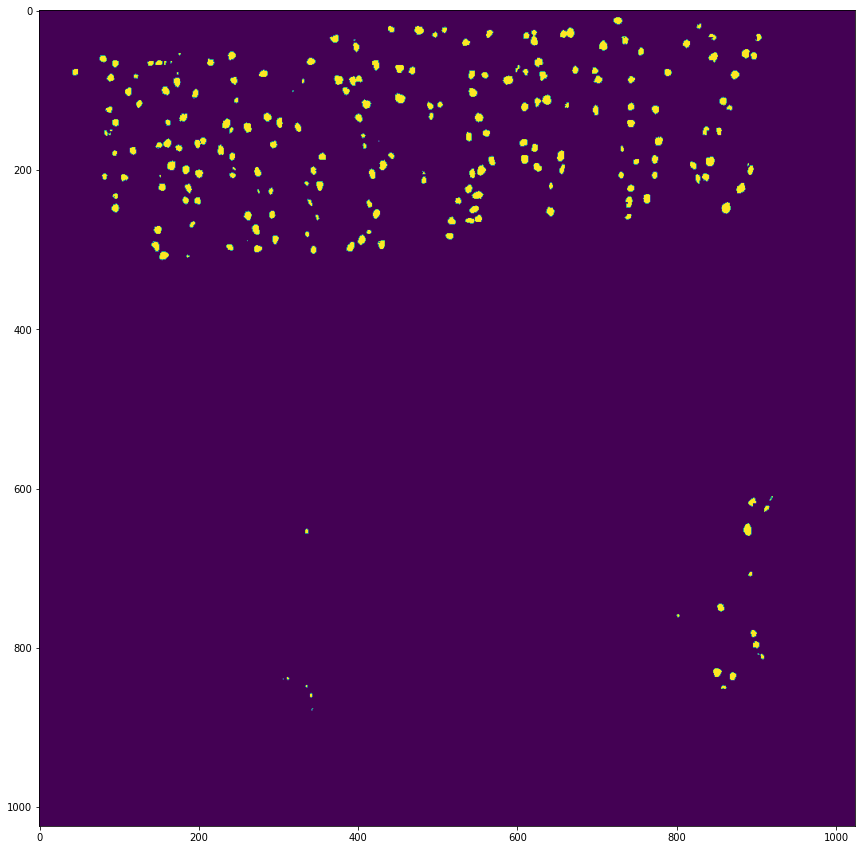

###### File 1e2425f28 ######


Shape: (26780, 32220, 3)
Prediction


0.4
Rezising
Plotting


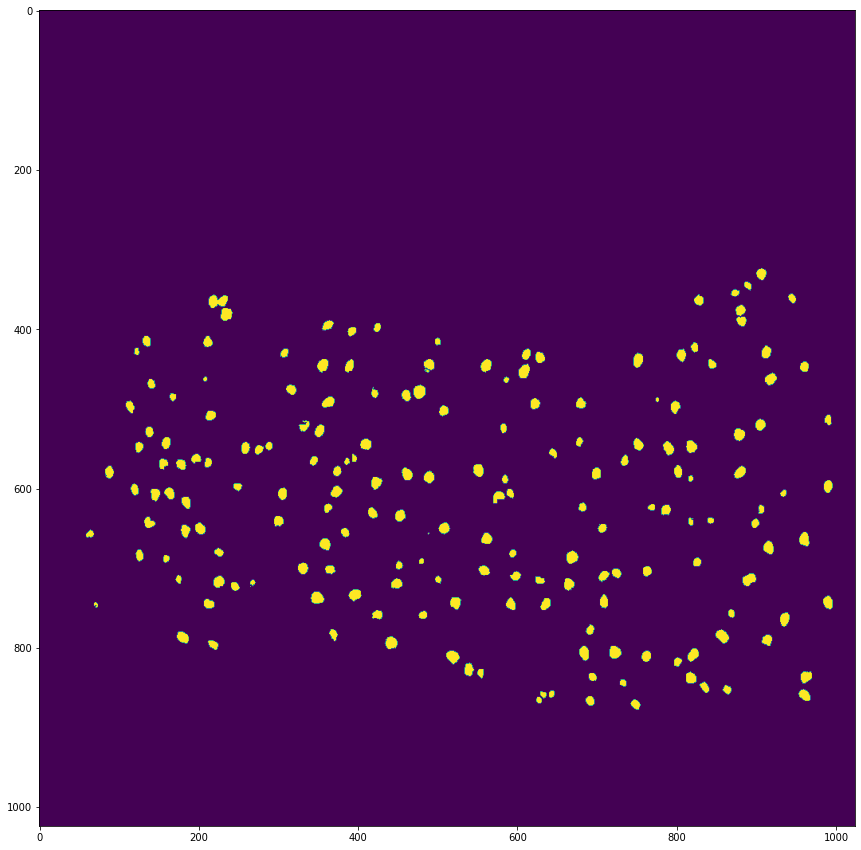

In [ ]:
def load_model_weights(model, file, strict=True):
    state = torch.load(file, map_location='cpu')
    stats = state['stats']
    model_state = state['model']
    model.load_state_dict(model_state, strict=strict)
    return model, stats

def rle_encode_less_memory(img):
    #the image should be transposed
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

# https://matjesg.github.io/deepflash2/data.html#BaseDataset
# Handling of different input shapes
@patch
def read_img(self:BaseDataset, *args, **kwargs):
    image = tifffile.imread(args[0])
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    elif image.shape[0] == 3:
        image = image.transpose(1, 2, 0)
    return image
class CONFIG():
    
    # data paths

    data_path = Path(abspath_curr+"/input") 
    model_file = abspath_curr + '/result/model/unet_resnet34.pth'
    
    # deepflash2 dataset (https://matjesg.github.io/deepflash2/data.html#TileDataset)
    scale = 3 # zoom facor (zoom out)
    tile_shape = (512, 512)
    padding = (100,100) # Border overlap for prediction

    # pytorch model (https://github.com/qubvel/segmentation_models.pytorch)
    encoder_name = "resnet34"
    encoder_weights = None
    in_channels = 3
    classes = 2
    
    # dataloader 
    batch_size = 16
    
    # prediction threshold
    threshold = 0.4
    
cfg = CONFIG()
# Model (see https://github.com/qubvel/segmentation_models.pytorch)
model = smp.Unet(encoder_name=cfg.encoder_name, 
                 encoder_weights=cfg.encoder_weights, 
                 in_channels=cfg.in_channels, 
                 classes=cfg.classes)
model, stats = load_model_weights(model, cfg.model_file)
batch_tfms = [Normalize.from_stats(*stats)]
names,preds = [],[]
arr_preds = []

for _, row in df_test.iterrows():
    idx = row.id
    print(f'###### File {idx} ######')
    f = cfg.data_path/'train'/f'{idx}.tiff'
    
    # Create deepflash2 dataset (including tiling and file conversion)
    ds = TileDataset([f], scale=cfg.scale, tile_shape=cfg.tile_shape, padding=cfg.padding)
    shape = ds.data[f.name].shape
    print('Shape:', shape)
    
    # Create fastai dataloader and learner
    dls = DataLoaders.from_dsets(ds, batch_size=cfg.batch_size, after_batch=batch_tfms, shuffle=False, drop_last=False)
    if torch.cuda.is_available(): dls.cuda(), model.cuda()
    learn = Learner(dls, model, loss_func='')
    
    # Predict tiles, see https://matjesg.github.io/deepflash2/learner.html#Learner.predict_tiles
    print('Prediction')
    res = learn.predict_tiles(dl=dls.train, path='/predict/', use_tta=False, uncertainty_estimates=False)
    
    # Load mask from softmax prediction > threshold
    th = 0.2 if idx=='d488c759a' else cfg.threshold
    print(th)
    msk = (res[0][f.name][..., 1]>th).astype(np.uint8)

    arr_preds.append(msk)
    print('Rezising')
    msk = cv2.resize(msk, (shape[1], shape[0]))

    rle = rle_encode_less_memory(msk)
    names.append(idx)
    preds.append(rle)
    
    # Plot Result
    print('Plotting')
    fig, ax = plt.subplots(figsize=(15,15))
    ax.imshow(cv2.resize(res[1][f.name][:].astype(np.uint8), (1024, 1024)))
    plt.show()

In [ ]:
real_masks = zarr.open_group(abspath_curr + f'/working/masks_scale2/labels')
dice_sum = 0

for i, row in df_test.iterrows():
   test_i = i-10
   idx = row.id
   print(f'###### File {idx} ######')

   real_mask = real_masks[idx]
   real_mask_shape = real_mask.shape

   pred_mask = arr_preds[test_i]
   pred_mask = cv2.resize(pred_mask, (real_mask_shape[1], real_mask_shape[0]))
   
   inter = (real_mask[:] * pred_mask[:]).sum().item()
   union = (real_mask[:] + pred_mask[:]).sum().item()
   cur_dice =  2 * inter / union   
   print("Dice for this image is: ",cur_dice)
   dice_sum += 2 * inter / union   

dice_sum/len(df_test)

###### File 4ef6695ce ######
Dice for this image is:  0.9274538113584022
###### File 26dc41664 ######
Dice for this image is:  0.9268649104406694
###### File c68fe75ea ######
Dice for this image is:  0.7832349546763281
###### File afa5e8098 ######
Dice for this image is:  0.8518395423367545
###### File 1e2425f28 ######
Dice for this image is:  0.924792363036172


0.8828371163696653

### 3. Conclusion & Discussion

Unet with efficentnet-b4 backbone shows higher dice coefficient then the one with resnet34.   
  
In the future experiments, flexible weight ratios for each image can be applied instead of pre- fixed weight ratios. For example, based on the area of background, cortex, medulla, and glomeruli in each image, we might be able to apply inverse class frequency weighting method for sampling tiles from each image. 

Also, the dice coefficient of third and fourth images were significantly lower than the others in both models. So, Finding patterns for these images with low performance could help build better model. 
Unfortunately, we have only five images for testing, so more images would help to find patterns within images that has a lower dice coefficient.

Furthermore, Instead of using Unet and efficientnet, other architectures and backbones could be applied for better performance but this could cost lots of GPU for training various combinations of architectures and backbone. 


### 4. Reference   
https://www.kaggle.com/matjes/hubmap-efficient-sampling-deepflash2-train  
https://www.kaggle.com/matjes/hubmap-efficient-sampling-deepflash2-sub  